# Synthetic Mortgage Loan Prepayment Data

Generate a panel of loan-month observations with a logit-based prepayment model driven by **age seasoning** and **rate incentive**.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def _sigmoid(x):
    """Numerically stable sigmoid."""
    return np.where(x >= 0,
                    1.0 / (1.0 + np.exp(-x)),
                    np.exp(x) / (1.0 + np.exp(x)))


def _cloglog(x):
    """Complementary log-log link: p = 1 - exp(-exp(x))."""
    return 1.0 - np.exp(-np.exp(np.clip(x, -30, 10)))


def age_effect(age, peak_age=24, tail_sigma=60):
    """Seasoning ramp: 0 at birth, peaks at peak_age, then slowly decays.

    Rising phase: (a/peak) * exp(1 - a/peak)
    Decay phase:  Gaussian tail exp(-0.5*((a-peak)/sigma)^2) for a gentler decline.
    Both sides have zero derivative at peak, so the join is C1-smooth.
    """
    a = np.asarray(age, dtype=float)
    ramp = (a / peak_age) * np.exp(1.0 - a / peak_age)
    tail = np.exp(-0.5 * ((a - peak_age) / tail_sigma) ** 2)
    return np.where(a <= peak_age, ramp, tail)


def incentive_effect(incentive, midpoint=0.02, steepness=300.0):
    """S-curve (sigmoid) for refinancing incentive."""
    return _sigmoid(steepness * (np.asarray(incentive) - midpoint))


def generate_synthetic_loan_data(
    n_months: int = 60,
    loans_per_month: int = 100,
    base_rates: np.ndarray | None = None,
    base_rate_start: float = 0.05,
    spread_mean: float = 0.020,
    spread_std: float = 0.005,
    peak_age: int = 24,
    prepay_intercept: float = -9.0,
    age_coeff: float = 3.5,
    incentive_coeff: float = 3.5,
    incentive_midpoint: float = 0.01,
    incentive_steepness: float = 200.0,
    interaction_coeff: float = 0.0,
    noise_std: float = 0.3,
    noise_hetero: float = 0.0,
    link: str = 'logit',
    seed: int = 42,
) -> pd.DataFrame:
    """Generate a synthetic loan-month panel with prepayment.

    Prepayment model (monthly):
        logit(p) = intercept
                   + age_coeff   * age_effect(age)
                   + inc_coeff   * incentive_effect(loan_rate - base_rate)
                   + interaction_coeff * age_effect * incentive_effect
                   + N(0, noise_std + noise_hetero * incentive_effect)
        p = link_fn(eta)   where link_fn is sigmoid (logit) or cloglog

    Returns a DataFrame with one row per (loan, month) while the loan is alive.
    """
    rng = np.random.default_rng(seed)
    link_fn = {'logit': _sigmoid, 'cloglog': _cloglog}[link]

    # --- base rate curve (deterministic default) ---
    # Smooth cosine cycle (~80-month period) with gentle upward drift.
    # Produces 2-3 big rate swings over 120 months, no micro-wiggles.
    if base_rates is None:
        t = np.arange(n_months, dtype=float)
        base_rates = (base_rate_start
                      + 0.012 * np.cos(2 * np.pi * t / 80)
                      + 0.0001 * t)
    base_rates = np.asarray(base_rates, dtype=float)
    assert len(base_rates) >= n_months

    frames: list[pd.DataFrame] = []

    for orig in range(n_months):
        # originate loans
        spreads = rng.normal(spread_mean, spread_std, loans_per_month).clip(min=0.003)
        loan_rates = base_rates[orig] + spreads
        active = np.ones(loans_per_month, dtype=bool)

        for cal in range(orig, n_months):
            n_act = active.sum()
            if n_act == 0:
                break

            age = cal - orig + 1
            cur_base = base_rates[cal]
            incentives = loan_rates[active] - cur_base

            a_eff = age_effect(age, peak_age)
            i_eff = incentive_effect(incentives, incentive_midpoint, incentive_steepness)

            noise_sigma = noise_std + noise_hetero * i_eff
            logit_p = (prepay_intercept
                       + age_coeff * a_eff
                       + incentive_coeff * i_eff
                       + interaction_coeff * a_eff * i_eff
                       + rng.normal(0, noise_sigma))
            probs = link_fn(logit_p)
            prepaid = rng.random(n_act) < probs

            act_idx = np.where(active)[0]
            frames.append(pd.DataFrame({
                'loan_id':            orig * loans_per_month + act_idx,
                'origination_month':  orig,
                'calendar_month':     cal,
                'loan_age':           age,
                'loan_rate':          loan_rates[active],
                'base_rate':          cur_base,
                'incentive':          incentives,
                'age_effect':         a_eff,
                'incentive_effect':   i_eff,
                'prepay_prob':        probs,
                'prepaid':            prepaid.astype(np.int8),
            }))

            active[act_idx[prepaid]] = False

    df = pd.concat(frames, ignore_index=True)
    df['loan_id'] = df['loan_id'].astype(int)
    return df

In [3]:
df = generate_synthetic_loan_data(
    n_months=120,
    loans_per_month=100,
    prepay_intercept=-15.0,
    age_coeff=6.0,
    incentive_coeff=4.0,
    interaction_coeff=2,
    noise_hetero=0.4,
    link='cloglog',
)

print(f"rows        : {len(df):,}")
print(f"unique loans: {df['loan_id'].nunique():,}")
print(f"prepay rate : {df['prepaid'].mean():.4f}  (monthly avg)")
print()
df.head(10)

rows        : 501,494
unique loans: 12,000
prepay rate : 0.0100  (monthly avg)



,loan_id,origination_month,calendar_month,loan_age,loan_rate,base_rate,incentive,age_effect,incentive_effect,prepay_prob,prepaid
0,0,0,0,1,0.083524,0.062,0.021524,0.108639,0.909267,0.000021,0
1,1,0,0,1,0.076800,0.062,0.014800,0.108639,0.723125,0.000027,0
2,2,0,0,1,0.085752,0.062,0.023752,0.108639,0.939939,0.000024,0
3,3,0,0,1,0.086703,0.062,0.024703,0.108639,0.949816,0.000053,0
4,4,0,0,1,0.072245,0.062,0.010245,0.108639,0.512239,0.000003,0
5,5,0,0,1,0.075489,0.062,0.013489,0.108639,0.667704,0.000009,0
6,6,0,0,1,0.082639,0.062,0.020639,0.108639,0.893580,0.000014,0
7,7,0,0,1,0.080419,0.062,0.018419,0.108639,0.843401,0.000017,0
8,8,0,0,1,0.081916,0.062,0.019916,0.108639,0.879022,0.000041,0
9,9,0,0,1,0.077735,0.062,0.015735,0.108639,0.758954,0.000005,0


In [4]:
df.to_parquet("sampling_data.parquet", index=False)
print(f"Saved {len(df):,} rows to sampling_data.parquet")

Saved 501,494 rows to sampling_data.parquet


## Model Components

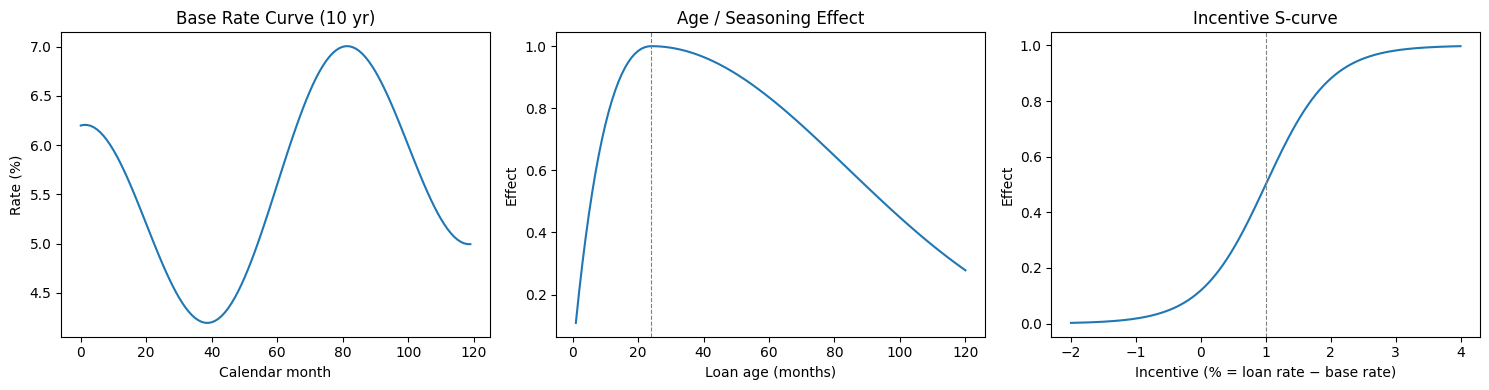

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1) base rate curve
t = np.arange(120, dtype=float)
br = 0.05 + 0.012 * np.cos(2 * np.pi * t / 80) + 0.0001 * t
axes[0].plot(t, br * 100)
axes[0].set(xlabel='Calendar month', ylabel='Rate (%)', title='Base Rate Curve (10 yr)')

# 2) age effect
ages = np.arange(1, 121)
axes[1].plot(ages, age_effect(ages, peak_age=24))
axes[1].axvline(24, ls='--', c='grey', lw=0.8)
axes[1].set(xlabel='Loan age (months)', ylabel='Effect', title='Age / Seasoning Effect')

# 3) incentive effect: incentive = loan_rate - base_rate
inc = np.linspace(-0.02, 0.04, 200)
axes[2].plot(inc * 100, incentive_effect(inc, midpoint=0.01, steepness=200))
axes[2].axvline(1.0, ls='--', c='grey', lw=0.8, label='midpoint')
axes[2].set(xlabel='Incentive (% = loan rate − base rate)', ylabel='Effect',
            title='Incentive S-curve')

fig.tight_layout()
plt.show()

## Data Analysis

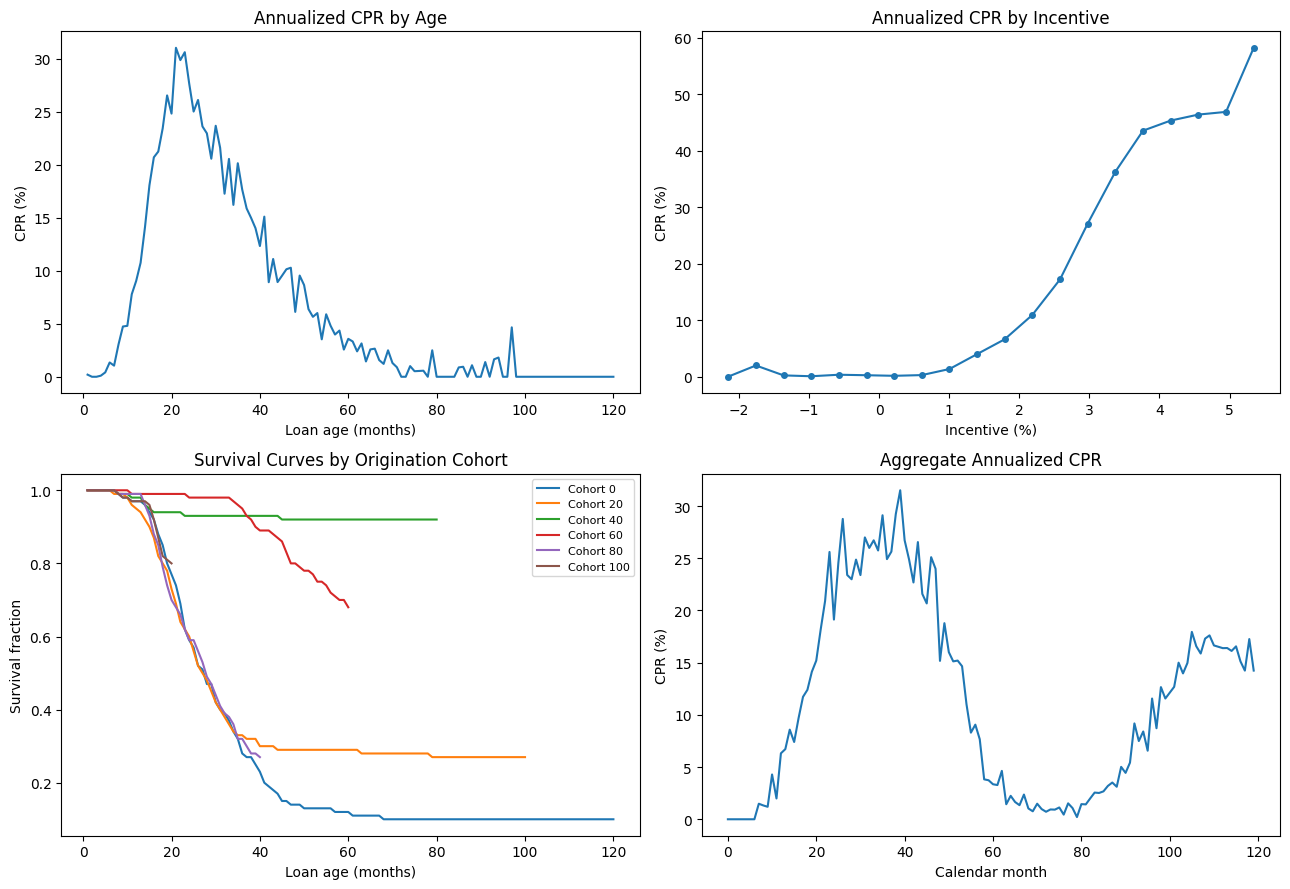

In [6]:
def smm_to_cpr(smm):
    """Annualize monthly prepay rate: CPR = 1 - (1-SMM)^12."""
    return 1 - (1 - smm) ** 12

fig, axes = plt.subplots(2, 2, figsize=(13, 9))

# (a) CPR vs loan age
by_age = df.groupby('loan_age')['prepaid'].mean()
axes[0, 0].plot(by_age.index, smm_to_cpr(by_age.values) * 100)
axes[0, 0].set(xlabel='Loan age (months)', ylabel='CPR (%)',
               title='Annualized CPR by Age')

# (b) CPR vs incentive (binned)
df['inc_bin'] = pd.cut(df['incentive'], bins=20)
by_inc = df.groupby('inc_bin', observed=True)['prepaid'].mean()
mid = np.array([iv.mid for iv in by_inc.index]) * 100
axes[0, 1].plot(mid, smm_to_cpr(by_inc.values) * 100, marker='o', ms=4)
axes[0, 1].set(xlabel='Incentive (%)', ylabel='CPR (%)',
               title='Annualized CPR by Incentive')

# (c) survival curves for selected cohorts
cohorts = [0, 20, 40, 60, 80, 100]
for c in cohorts:
    cohort = df[df['origination_month'] == c]
    n_orig = cohort[cohort['loan_age'] == 1].shape[0]
    cum_prepay = cohort.groupby('loan_age')['prepaid'].sum().cumsum()
    survival = 1.0 - cum_prepay / n_orig
    axes[1, 0].plot(survival.index, survival.values, label=f'Cohort {c}')
axes[1, 0].set(xlabel='Loan age (months)', ylabel='Survival fraction',
               title='Survival Curves by Origination Cohort')
axes[1, 0].legend(fontsize=8)

# (d) aggregate CPR over calendar time
by_cal = df.groupby('calendar_month')['prepaid'].agg(['sum', 'count'])
by_cal['smm'] = by_cal['sum'] / by_cal['count']
by_cal['cpr'] = smm_to_cpr(by_cal['smm'])
axes[1, 1].plot(by_cal.index, by_cal['cpr'] * 100)
axes[1, 1].set(xlabel='Calendar month', ylabel='CPR (%)',
               title='Aggregate Annualized CPR')

fig.tight_layout()
plt.show()

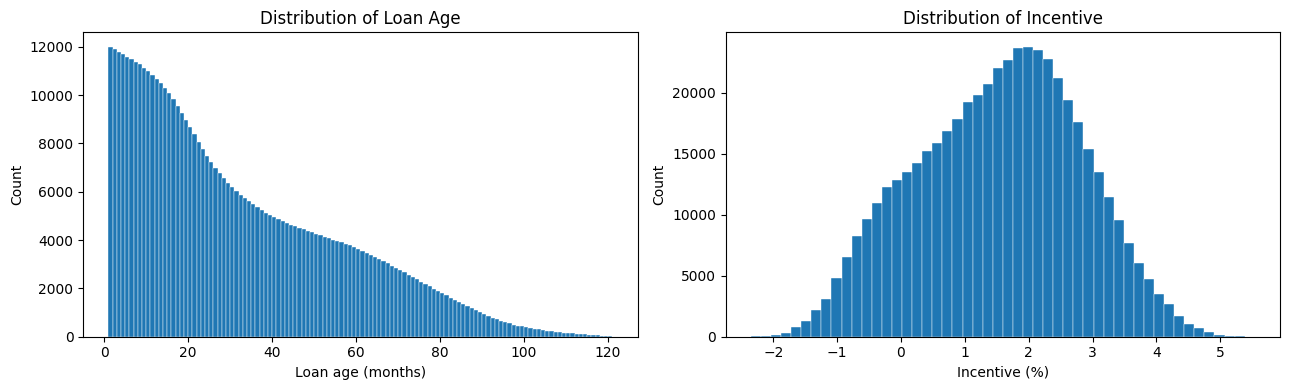

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(13, 4))

axes[0].hist(df['loan_age'], bins=range(1, df['loan_age'].max() + 2), edgecolor='white', linewidth=0.3)
axes[0].set(xlabel='Loan age (months)', ylabel='Count', title='Distribution of Loan Age')

axes[1].hist(df['incentive'] * 100, bins=50, edgecolor='white', linewidth=0.3)
axes[1].set(xlabel='Incentive (%)', ylabel='Count', title='Distribution of Incentive')

fig.tight_layout()
plt.show()

## GAM Fit

In [8]:
from pygam import LogisticGAM, s

df_model = df.copy()
df_model['loan_age'] = df_model['loan_age'].clip(upper=80)
df_model['incentive'] = df_model['incentive'].clip(-0.02, 0.04)

X = df_model[['loan_age', 'incentive']].values
y = df_model['prepaid'].values

gam = LogisticGAM(s(0, lam=1) + s(1, lam=1)).fit(X, y)
gam.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      25.883
Link Function:                        LogitLink Log Likelihood:                                -22571.1084
Number of Samples:                       501494 AIC:                                            45193.9828
                                                AICc:                                           45193.9857
                                                UBRE:                                               2.0902
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1963
Feature Function                  Lam

C:\Users\yimingz\AppData\Local\Temp\ipykernel_13136\689262531.py:11: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


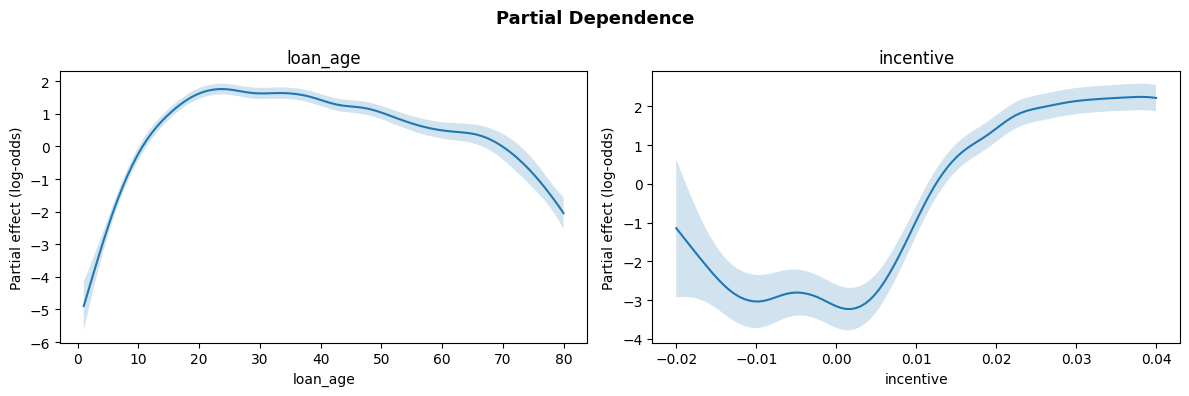

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for i, name in enumerate(['loan_age', 'incentive']):
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)
    axes[i].plot(XX[:, i], pdep)
    axes[i].fill_between(XX[:, i], confi[:, 0], confi[:, 1], alpha=0.2)
    axes[i].set(xlabel=name, ylabel='Partial effect (log-odds)', title=f'{name}')

fig.suptitle('Partial Dependence', fontsize=13, fontweight='bold')
fig.tight_layout()
plt.show()

In [10]:
from quantbullet.plot.binned_plots import plot_binned_actual_vs_pred_plotnine

df_model['pred_gam'] = gam.predict_proba(X)
df_model['incentive_pct'] = df_model['incentive'] * 100
# round the incentive to its closest 0.1
df_model['incentive_pct_discrete'] = np.round(df_model['incentive_pct'], 1)

smm_to_cpr_pct = lambda x: (1 - (1 - x) ** 12) * 100

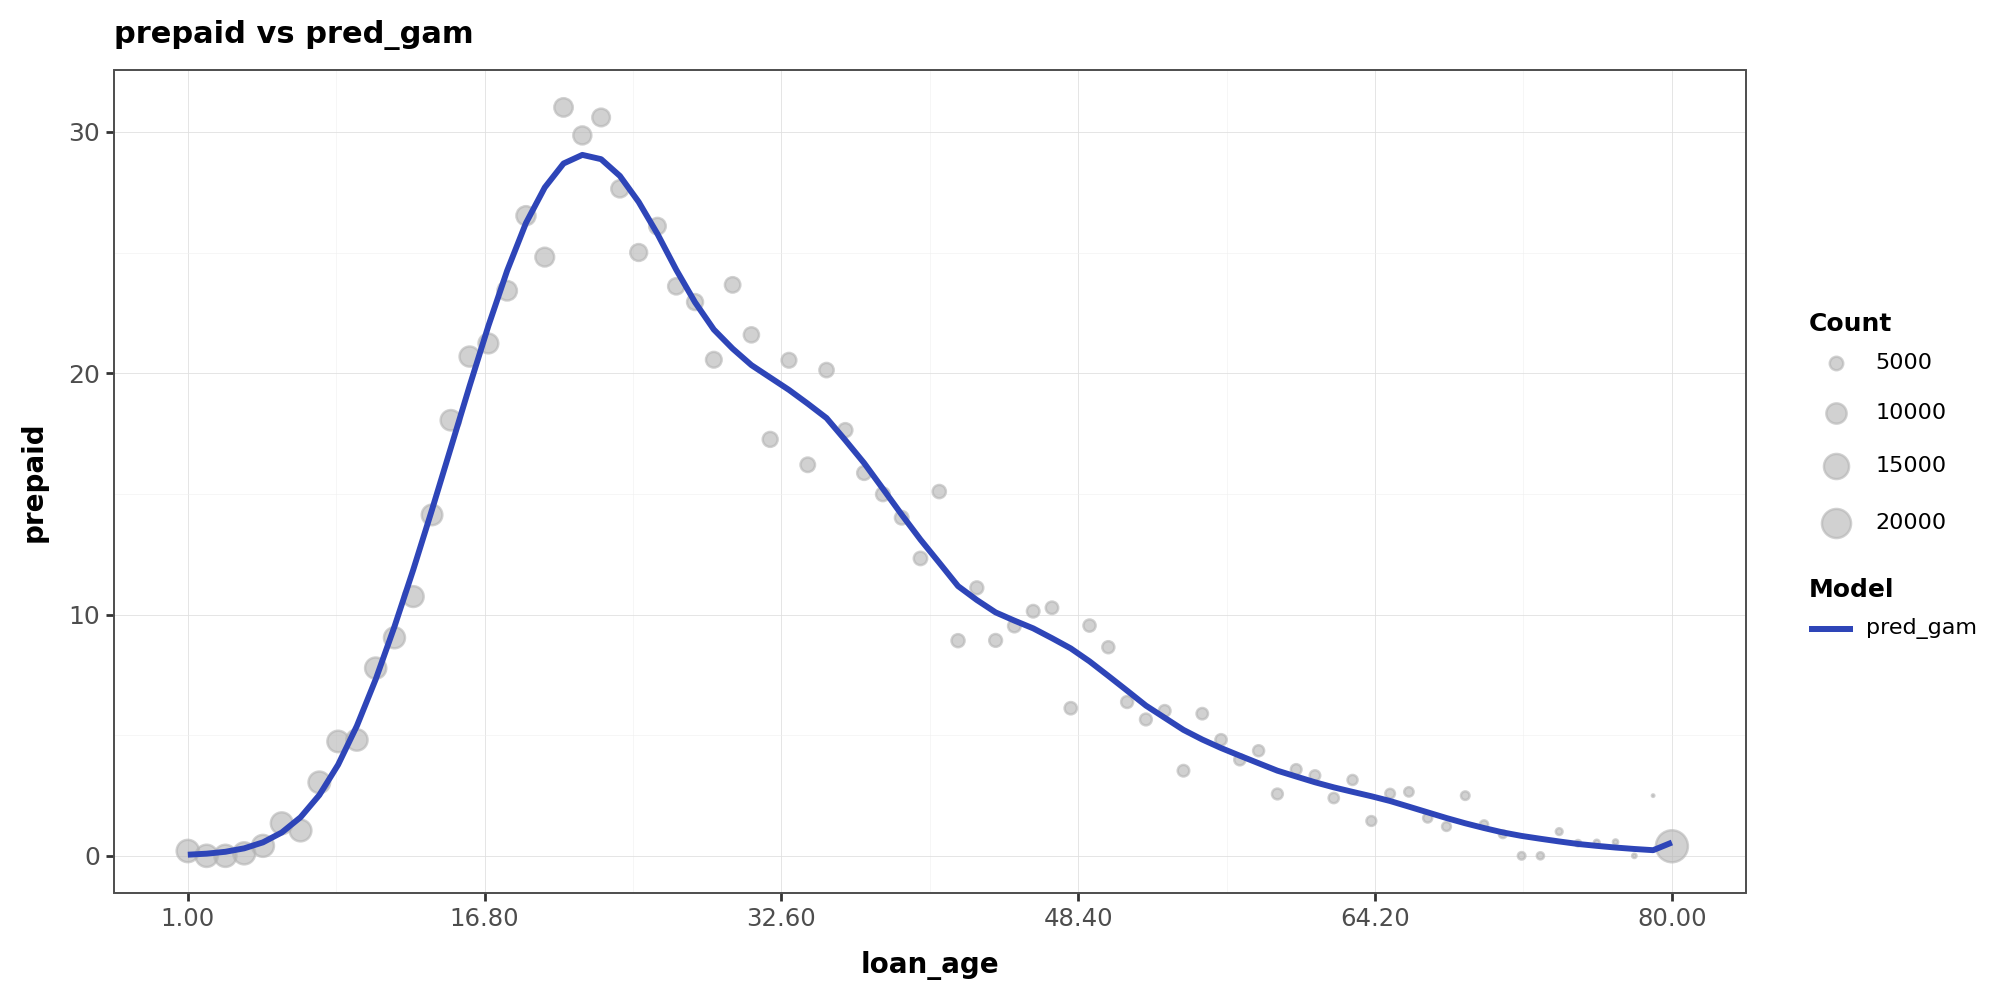

In [11]:
plot_binned_actual_vs_pred_plotnine(
    df_model, x_col='loan_age', act_col='prepaid', pred_col='pred_gam',
    bins=False, y_transform=smm_to_cpr_pct, figsize=(10, 5),
)

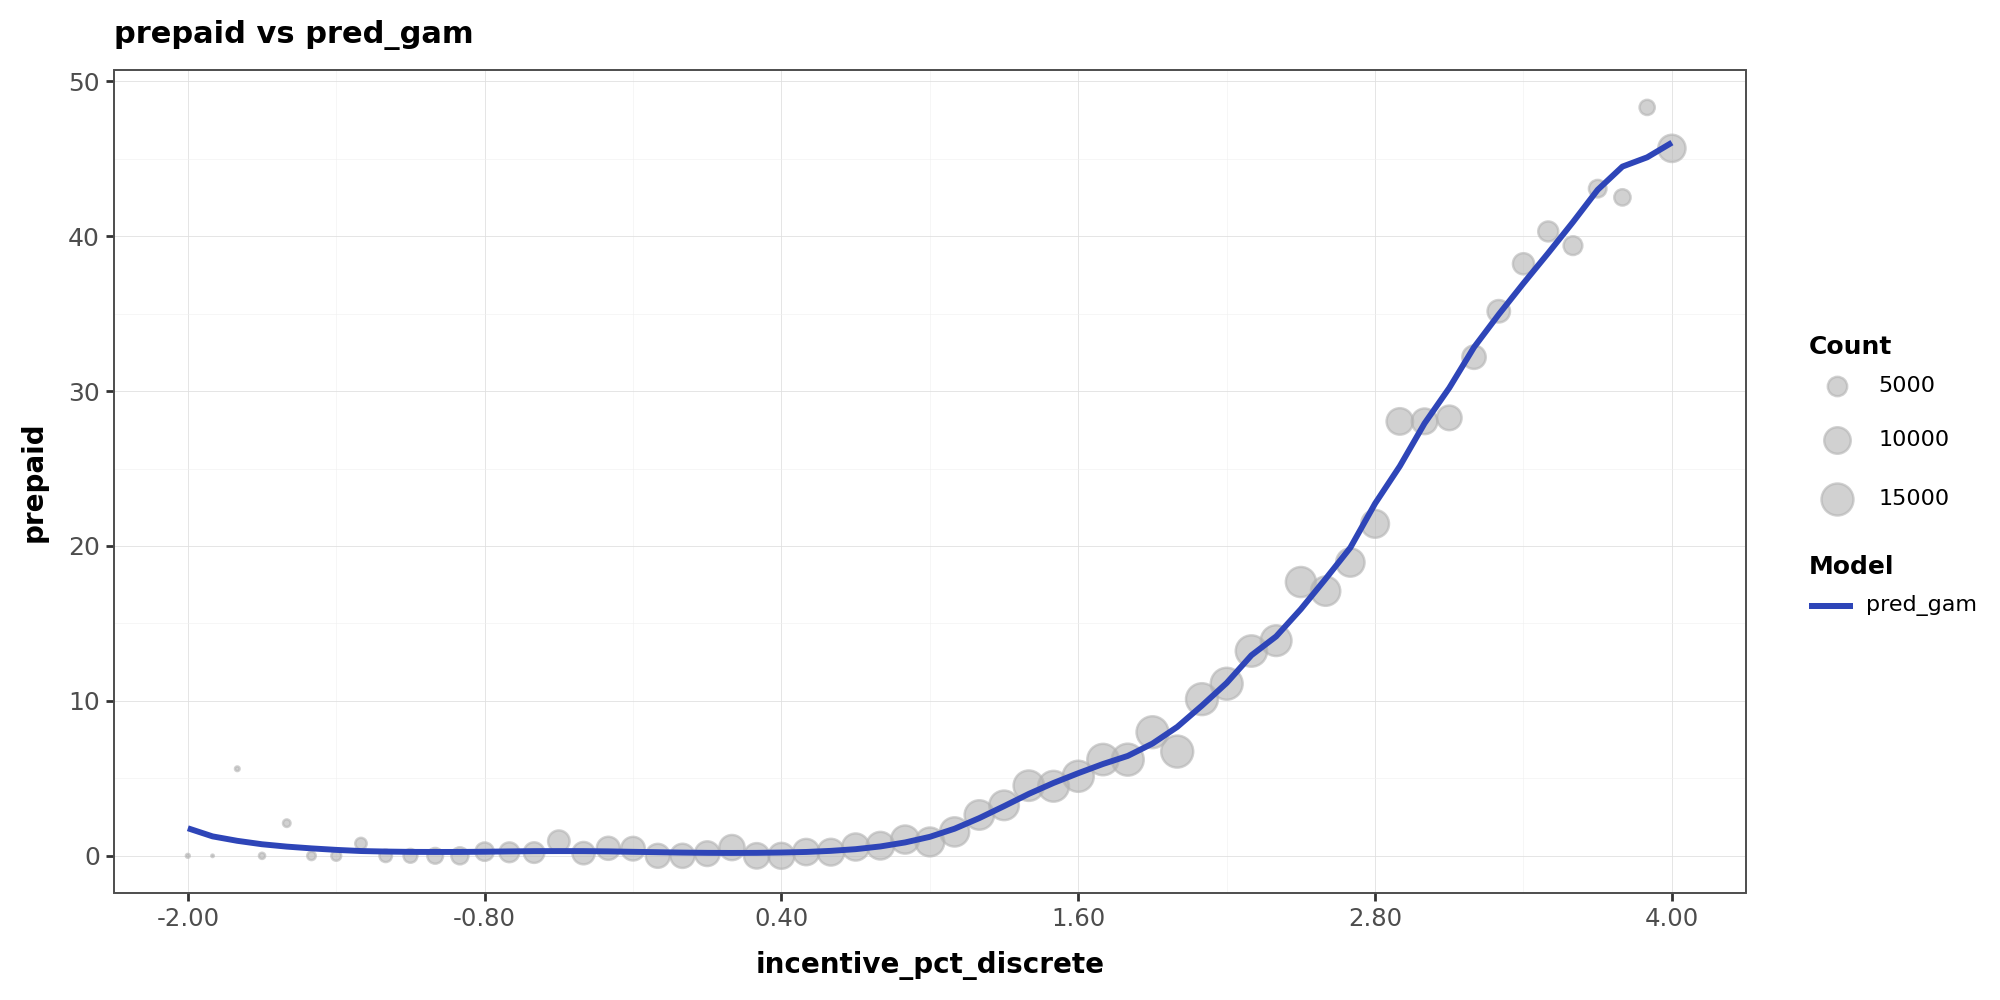

In [12]:
plot_binned_actual_vs_pred_plotnine(
    df_model, x_col='incentive_pct_discrete', act_col='prepaid', pred_col='pred_gam',
    bins=False, y_transform=smm_to_cpr_pct, figsize=(10, 5),
)

## Downsampling & Probability Calibration


Keep all prepaid events, downsample non-events to a target event rate, refit GAM, then correct predictions via:
1. **Prior correction** (Bayesian recalibration)
2. **King & Zeng intercept correction**

In [ ]:
target_event_rate = 0.5

rng_ds = np.random.default_rng(42)
prepaid_mask = df_model['prepaid'] == 1
n_prepaid = prepaid_mask.sum()

n_unprepaid_target = int(n_prepaid * (1 - target_event_rate) / target_event_rate)
unprepaid_idx = df_model.index[~prepaid_mask].to_numpy()
sampled_idx = rng_ds.choice(unprepaid_idx, size=n_unprepaid_target, replace=False)

df_down = pd.concat([df_model[prepaid_mask], df_model.loc[sampled_idx]]).sort_index()

pi_true = df_model['prepaid'].mean()
pi_down = df_down['prepaid'].mean()

print(f"Full data:        {len(df_model):>10,} rows  |  event rate = {pi_true:.4f}")
print(f"Downsampled data: {len(df_down):>10,} rows  |  event rate = {pi_down:.4f}")

Full data:           501,494 rows  |  event rate = 0.0100
Downsampled data:     50,150 rows  |  event rate = 0.1000


In [14]:
X_down = df_down[['loan_age', 'incentive']].values
y_down = df_down['prepaid'].values

gam_down = LogisticGAM(s(0, lam=1) + s(1, lam=1)).fit(X_down, y_down)
gam_down.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     25.4424
Link Function:                        LogitLink Log Likelihood:                                -11386.9152
Number of Samples:                        50150 AIC:                                            22824.7152
                                                AICc:                                           22824.7442
                                                UBRE:                                               2.4555
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.3015
Feature Function                  Lam

C:\Users\yimingz\AppData\Local\Temp\ipykernel_13136\1450836720.py:5: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 



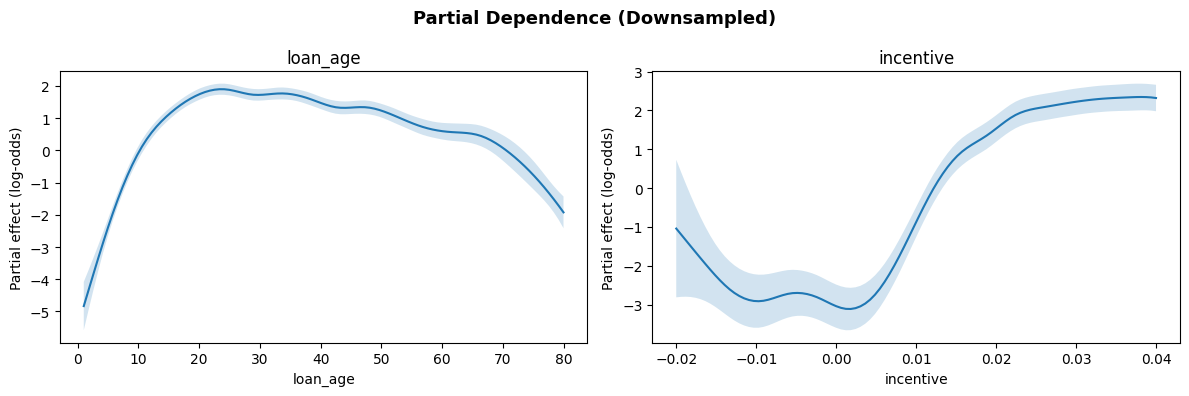

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for i, name in enumerate(['loan_age', 'incentive']):
    XX = gam_down.generate_X_grid(term=i)
    pdep, confi = gam_down.partial_dependence(term=i, X=XX, width=0.95)
    axes[i].plot(XX[:, i], pdep)
    axes[i].fill_between(XX[:, i], confi[:, 0], confi[:, 1], alpha=0.2)
    axes[i].set(xlabel=name, ylabel='Partial effect (log-odds)', title=f'{name}')

fig.suptitle('Partial Dependence (Downsampled)', fontsize=13, fontweight='bold')
fig.tight_layout()
plt.show()

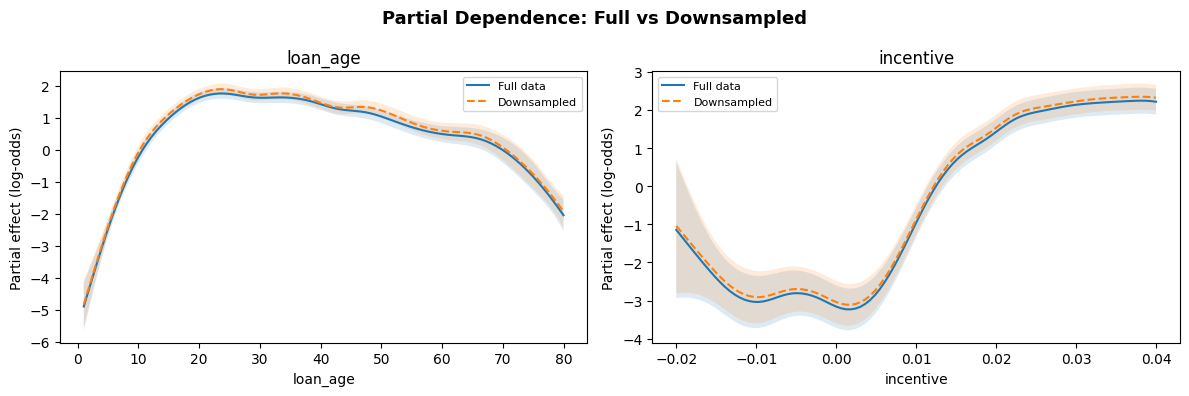

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for i, name in enumerate(['loan_age', 'incentive']):
    XX_f = gam.generate_X_grid(term=i)
    pdep_f, confi_f = gam.partial_dependence(term=i, X=XX_f, width=0.95)
    axes[i].plot(XX_f[:, i], pdep_f, label='Full data')
    axes[i].fill_between(XX_f[:, i], confi_f[:, 0], confi_f[:, 1], alpha=0.15)

    XX_d = gam_down.generate_X_grid(term=i)
    pdep_d, confi_d = gam_down.partial_dependence(term=i, X=XX_d, width=0.95)
    axes[i].plot(XX_d[:, i], pdep_d, ls='--', label='Downsampled')
    axes[i].fill_between(XX_d[:, i], confi_d[:, 0], confi_d[:, 1], alpha=0.15)

    axes[i].set(xlabel=name, ylabel='Partial effect (log-odds)', title=f'{name}')
    axes[i].legend(fontsize=8)

fig.suptitle('Partial Dependence: Full vs Downsampled', fontsize=13, fontweight='bold')
fig.tight_layout()
plt.show()

In [17]:
p_raw = np.clip(gam_down.predict_proba(X), 1e-10, 1 - 1e-10)

# Method 1: Bayesian prior correction (exact)
#   w = pi*(1-pi') / (pi'*(1-pi)),  p_corrected = w*p / (1 + (w-1)*p)
w = (pi_true * (1 - pi_down)) / (pi_down * (1 - pi_true))
df_model['pred_down_prior'] = (w * p_raw) / (1 + (w - 1) * p_raw)

# Method 2: King & Zeng intercept correction (shift logit by log-odds ratio)
#   logit_corrected = logit_raw + log(pi*(1-pi') / (pi'*(1-pi)))
kz_correction = np.log((pi_true * (1 - pi_down)) / (pi_down * (1 - pi_true)))
logit_raw = np.log(p_raw / (1 - p_raw))
df_model['pred_down_kz'] = _sigmoid(logit_raw + kz_correction)

# Uncorrected (for comparison)
df_model['pred_down_raw'] = p_raw

print(f"KZ intercept correction: {kz_correction:+.4f}")
print(f"Prior weight w:         {w:.4f}")
print()
print("Mean predicted probability (on full data):")
print(f"  Full-data GAM:          {df_model['pred_gam'].mean():.5f}")
print(f"  Downsampled raw:        {df_model['pred_down_raw'].mean():.5f}")
print(f"  Downsampled + prior:    {df_model['pred_down_prior'].mean():.5f}")
print(f"  Downsampled + KZ:       {df_model['pred_down_kz'].mean():.5f}")
print(f"  Actual:                 {df_model['prepaid'].mean():.5f}")

KZ intercept correction: -2.3979
Prior weight w:         0.0909

Mean predicted probability (on full data):
  Full-data GAM:          0.01000
  Downsampled raw:        0.08152
  Downsampled + prior:    0.00998
  Downsampled + KZ:       0.00998
  Actual:                 0.01000


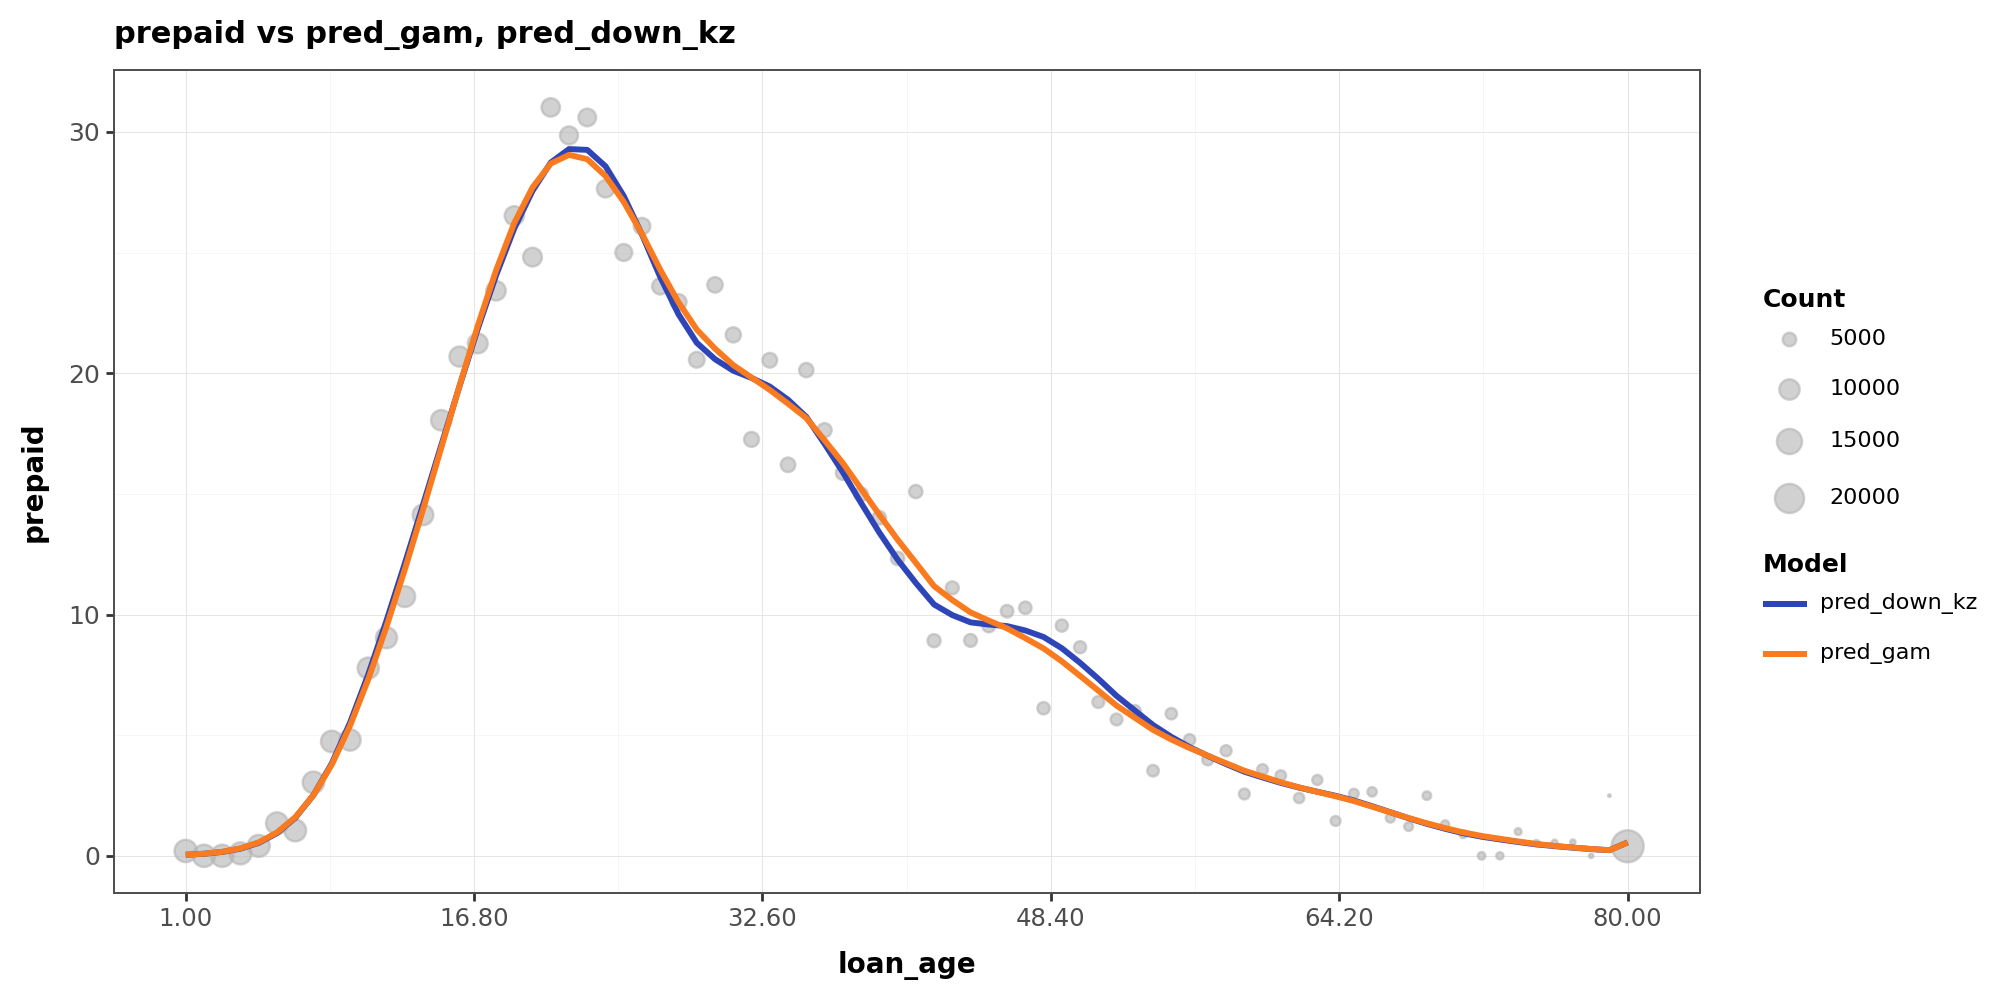

In [18]:
pred_cols = ['pred_gam', 'pred_down_prior', 'pred_down_kz', 'pred_down_raw']
pred_cols = ['pred_gam', 'pred_down_kz']

plot_binned_actual_vs_pred_plotnine(
    df_model, x_col='loan_age', act_col='prepaid', pred_col=pred_cols,
    bins=False, y_transform=smm_to_cpr_pct, figsize=(10, 5),
)

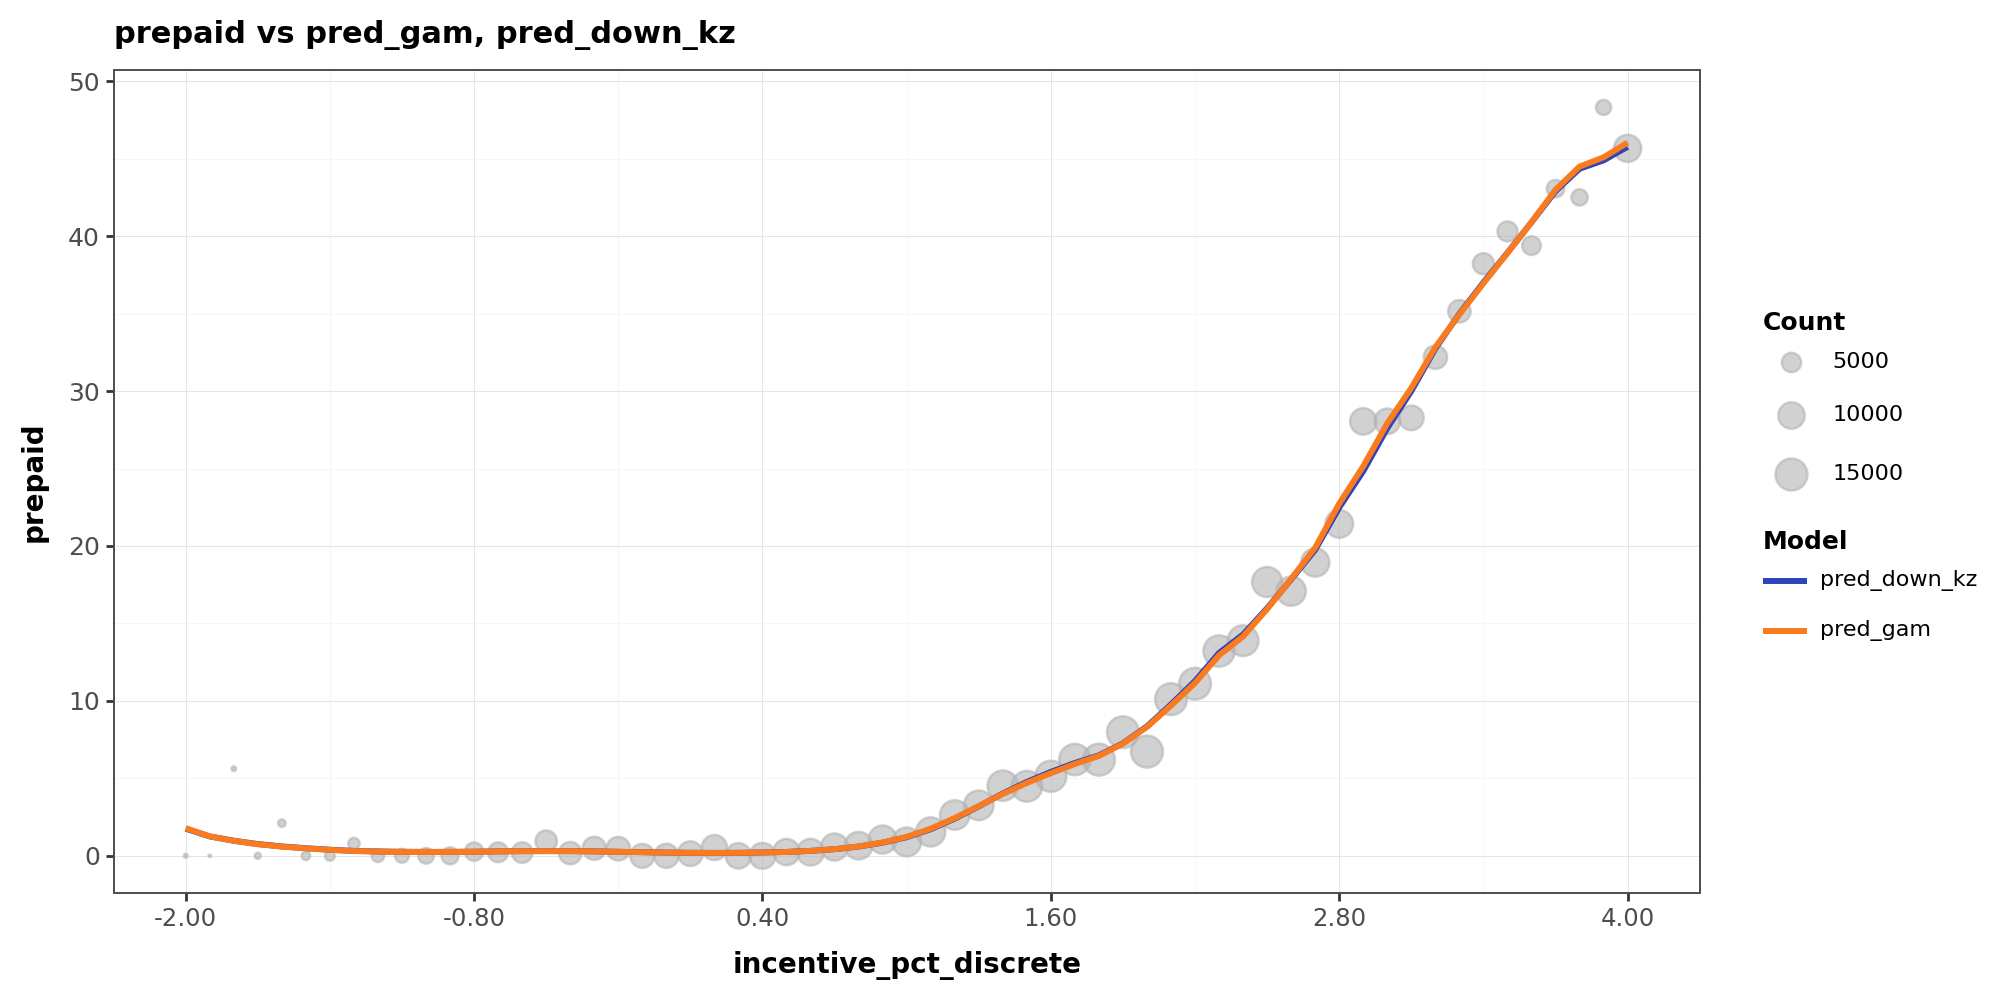

In [19]:
plot_binned_actual_vs_pred_plotnine(
    df_model, x_col='incentive_pct_discrete', act_col='prepaid', pred_col=pred_cols,
    bins=False, y_transform=smm_to_cpr_pct, figsize=(10, 5),
)

## `mgcv` Fit

In [20]:
from quantbullet.r.mgcv_bam import MgcvBamWrapper

Error importing in API mode: ImportError('On Windows, cffi mode "ANY" is only "ABI".')
Trying to import in ABI mode.


In [21]:
model = MgcvBamWrapper()

- Project 'C:/Users/yimingz/repo/quantbullet' loaded. [renv 1.1.5]
- The project is out-of-sync -- use `renv::status()` for details.


In [22]:
df_model.head( 10 )

,loan_id,origination_month,calendar_month,loan_age,loan_rate,base_rate,incentive,age_effect,incentive_effect,prepay_prob,prepaid,inc_bin,pred_gam,incentive_pct,incentive_pct_discrete,pred_down_prior,pred_down_kz,pred_down_raw
0,0,0,0,1,0.083524,0.062,0.021524,0.108639,0.909267,0.000021,0,"(0.0199, 0.0238]",0.000047,2.152359,2.2,0.000045,0.000045,0.000491
1,1,0,0,1,0.076800,0.062,0.014800,0.108639,0.723125,0.000027,0,"(0.012, 0.0159]",0.000017,1.480008,1.5,0.000016,0.000016,0.000178
2,2,0,0,1,0.085752,0.062,0.023752,0.108639,0.939939,0.000024,0,"(0.0199, 0.0238]",0.000058,2.375226,2.4,0.000056,0.000056,0.000614
3,3,0,0,1,0.086703,0.062,0.024703,0.108639,0.949816,0.000053,0,"(0.0238, 0.0278]",0.000061,2.470282,2.5,0.000059,0.000059,0.000644
4,4,0,0,1,0.072245,0.062,0.010245,0.108639,0.512239,0.000003,0,"(0.00806, 0.012]",0.000004,1.024482,1.0,0.000004,0.000004,0.000039
5,5,0,0,1,0.075489,0.062,0.013489,0.108639,0.667704,0.000009,0,"(0.012, 0.0159]",0.000012,1.348910,1.3,0.000012,0.000012,0.000127
6,6,0,0,1,0.082639,0.062,0.020639,0.108639,0.893580,0.000014,0,"(0.0199, 0.0238]",0.000041,2.063920,2.1,0.000039,0.000039,0.000429
7,7,0,0,1,0.080419,0.062,0.018419,0.108639,0.843401,0.000017,0,"(0.0159, 0.0199]",0.000029,1.841879,1.8,0.000028,0.000028,0.000307
8,8,0,0,1,0.081916,0.062,0.019916,0.108639,0.879022,0.000041,0,"(0.0199, 0.0238]",0.000037,1.991599,2.0,0.000035,0.000035,0.000383
9,9,0,0,1,0.077735,0.062,0.015735,0.108639,0.758954,0.000005,0,"(0.012, 0.0159]",0.000020,1.573478,1.6,0.000019,0.000019,0.000214


In [23]:
model.fit(
    df = df_model,
    formula = "prepaid ~ s( loan_age ) + s( incentive )",
    family = "binomial"
)

Model fitted from DataFrame: py_df_to_r=1.71s | bam_fit=3.18s


MgcvBamWrapper(fitted, formula='prepaid ~ s( loan_age ) + s( incentive )')

In [24]:
df_model['pred_mgcv'] = model.predict( df=df_model )

[strip_gam_object] 42 MB → 7 MB
[R predict_bam] n=501494 | convert=0.000s strip=0.017s predict=0.138s | total=0.155s
Predictions made from DataFrame[501494]: select_cols=0.00s | py_to_r=1.68s | r_predict=0.17s | r_to_py=0.00s | total=1.85s


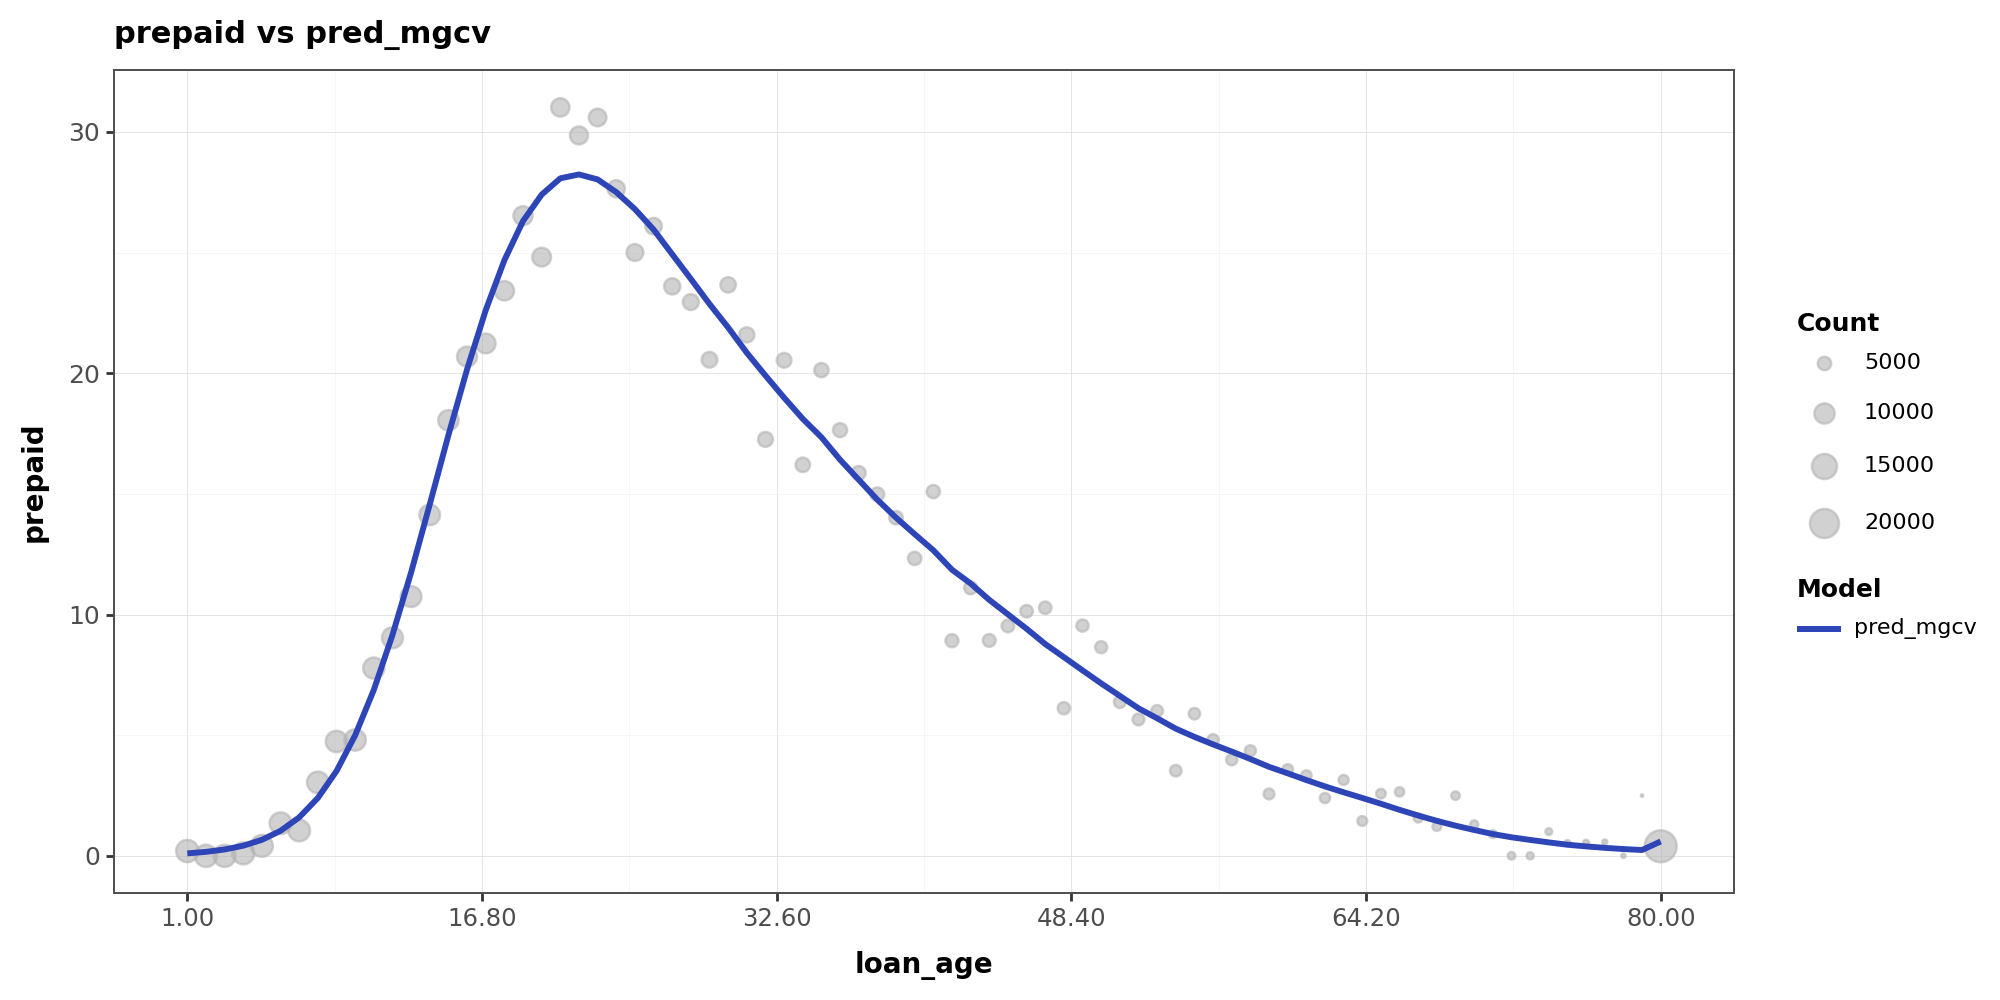

In [25]:
plot_binned_actual_vs_pred_plotnine(
    df_model, x_col='loan_age', act_col='prepaid', pred_col='pred_mgcv',
    bins=False, y_transform=smm_to_cpr_pct, figsize=(10, 5),
)

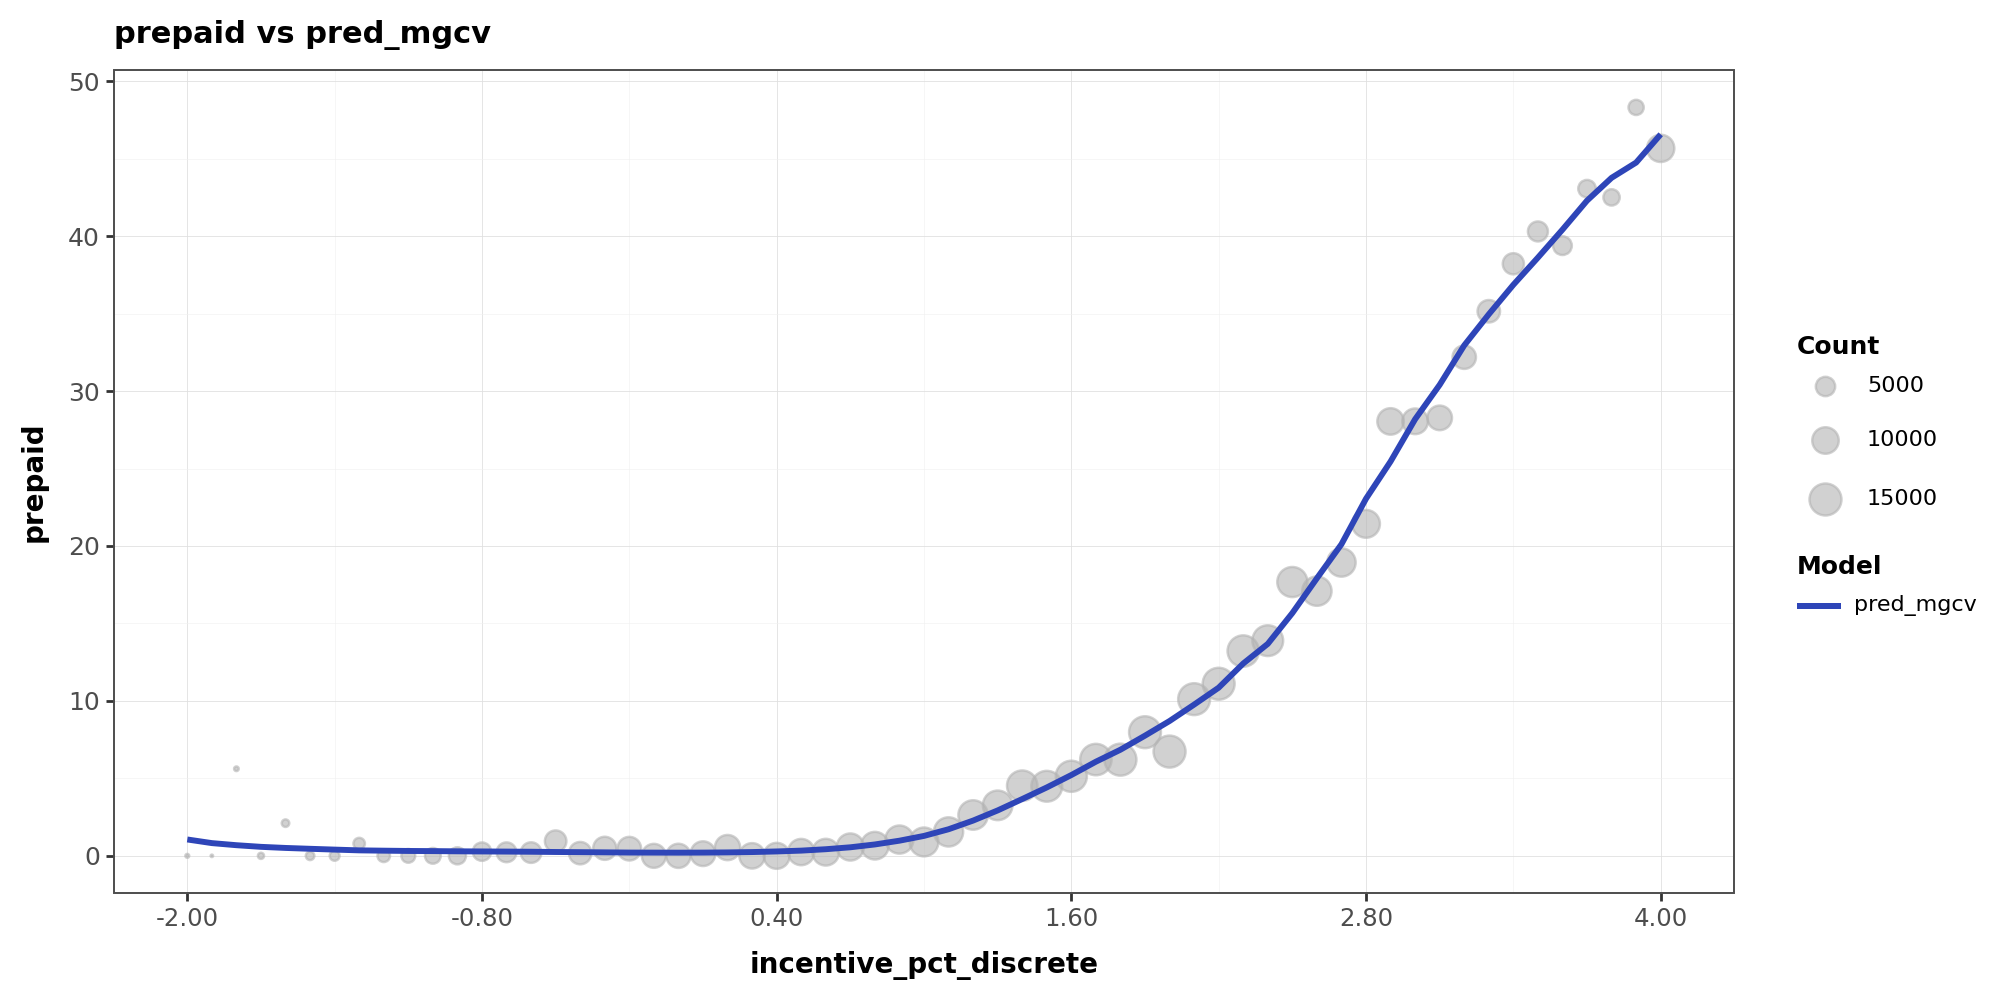

In [26]:
plot_binned_actual_vs_pred_plotnine(
    df_model, x_col='incentive_pct_discrete', act_col='prepaid', pred_col='pred_mgcv',
    bins=False, y_transform=smm_to_cpr_pct, figsize=(10, 5),
)

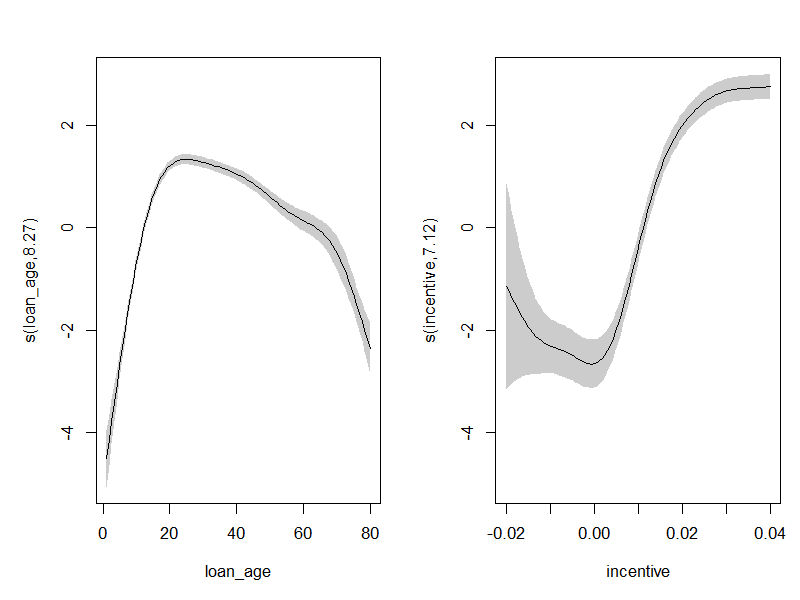

In [27]:
model.plot(width=800, height=600, dpi=100)

## `mgcv` Fit on Downsampled Data (Post-hoc KZ Correction)

A constant `offset()` in the formula cancels out: the intercept absorbs it during fitting, then it's added back during prediction, netting to zero.
Instead, fit without offset, predict on the link (log-odds) scale, and apply the KZ correction post-hoc.

In [28]:
mgcv_down_model = MgcvBamWrapper()

In [29]:
df_down['correction'] = -kz_correction
df_model['correction'] = 0

In [30]:
mgcv_down_model.fit(
    df = df_down,
    formula = "prepaid ~ s( loan_age ) + s( incentive ) + offset( correction )",
    family = "binomial"
)

Model fitted from DataFrame: py_df_to_r=0.25s | bam_fit=0.29s


MgcvBamWrapper(fitted, formula='prepaid ~ s( loan_age ) + s( incentive ) + offset( correction )')

In [31]:
df_model['pred_mgcv_down_offset'] = mgcv_down_model.predict(df=df_model)

[strip_gam_object] 4 MB → 0 MB
[R predict_bam] n=501494 | convert=0.000s strip=0.017s predict=0.261s | total=0.278s
Predictions made from DataFrame[501494]: select_cols=0.00s | py_to_r=2.30s | r_predict=0.29s | r_to_py=0.00s | total=2.59s


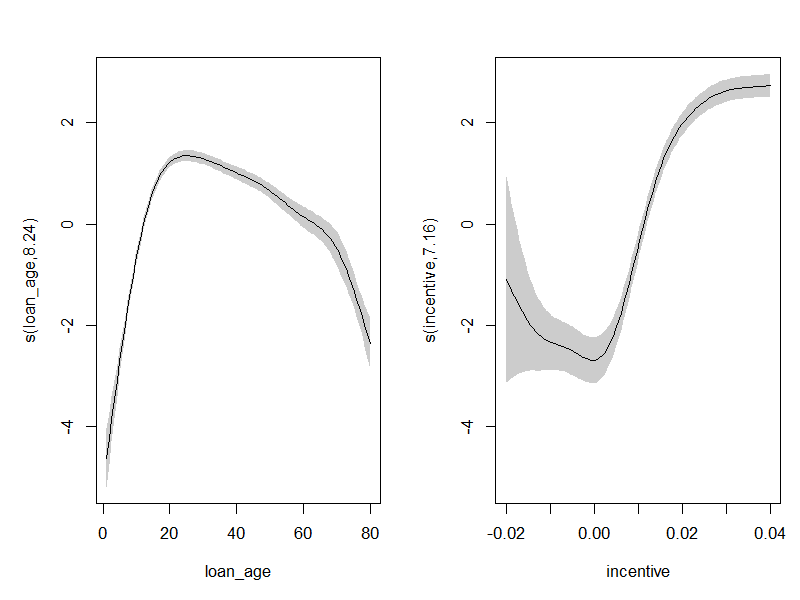

In [32]:
mgcv_down_model.plot(width=800, height=600, dpi=100)

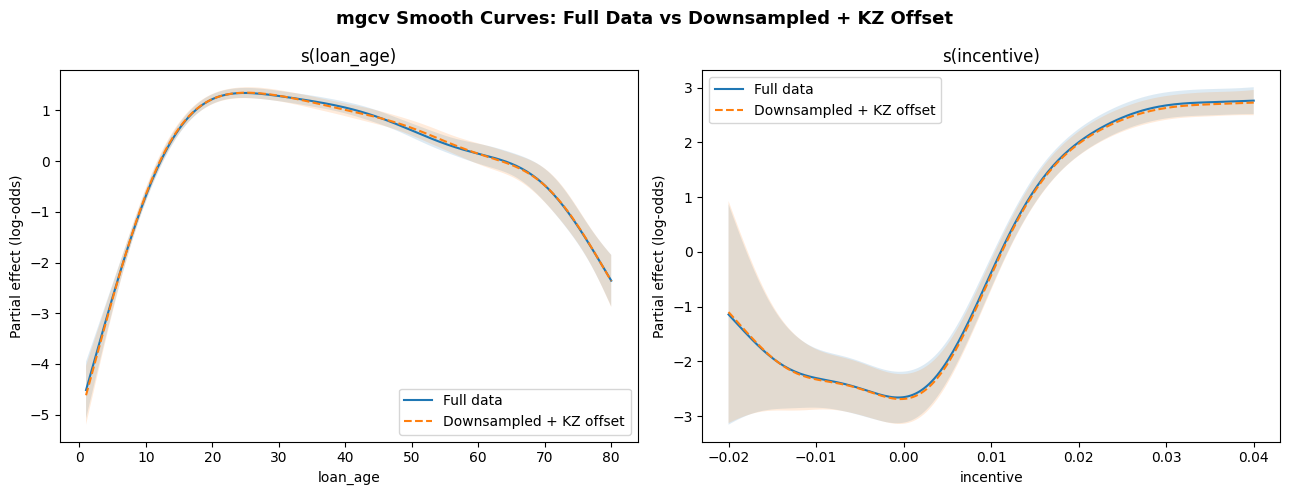

In [33]:
comp_full = model.extract_components()
comp_down = mgcv_down_model.extract_components()

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

for i, term_label in enumerate(['s(loan_age)', 's(incentive)']):
    ax = axes[i]

    full_curve = comp_full['smooths'][term_label]
    ax.plot(full_curve['x'], full_curve['fit'], label='Full data')
    ax.fill_between(
        full_curve['x'],
        full_curve['fit'] - 1.96 * full_curve['se'],
        full_curve['fit'] + 1.96 * full_curve['se'],
        alpha=0.15,
    )

    down_curve = comp_down['smooths'][term_label]
    ax.plot(down_curve['x'], down_curve['fit'], '--', label='Downsampled + KZ offset')
    ax.fill_between(
        down_curve['x'],
        down_curve['fit'] - 1.96 * down_curve['se'],
        down_curve['fit'] + 1.96 * down_curve['se'],
        alpha=0.15,
    )

    var_name = full_curve['var'].iloc[0]
    ax.set(xlabel=var_name, ylabel='Partial effect (log-odds)', title=term_label)
    ax.legend()

fig.suptitle('mgcv Smooth Curves: Full Data vs Downsampled + KZ Offset', fontsize=13, fontweight='bold')
fig.tight_layout()
plt.show()

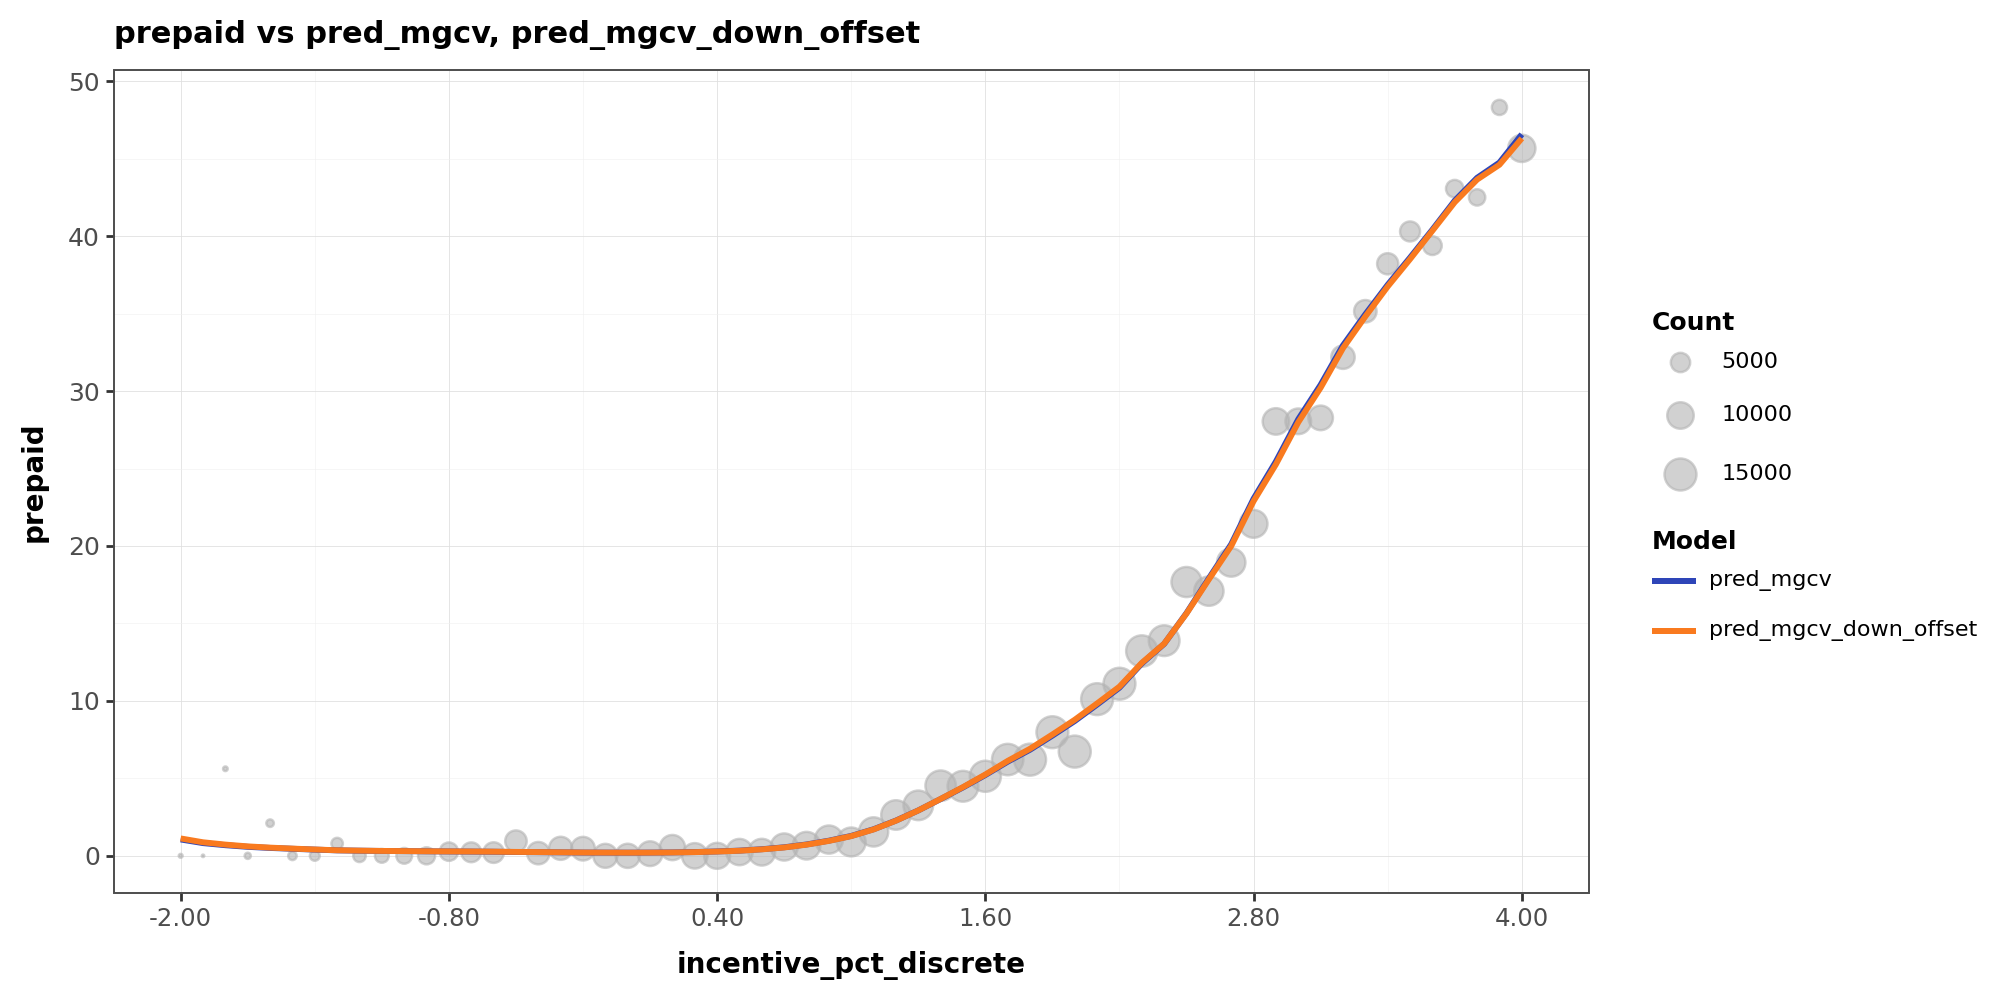

In [34]:
plot_binned_actual_vs_pred_plotnine(
    df_model, x_col='incentive_pct_discrete', act_col='prepaid', pred_col=['pred_mgcv', 'pred_mgcv_down_offset'],
    bins=False, y_transform=smm_to_cpr_pct, figsize=(10, 5),
)

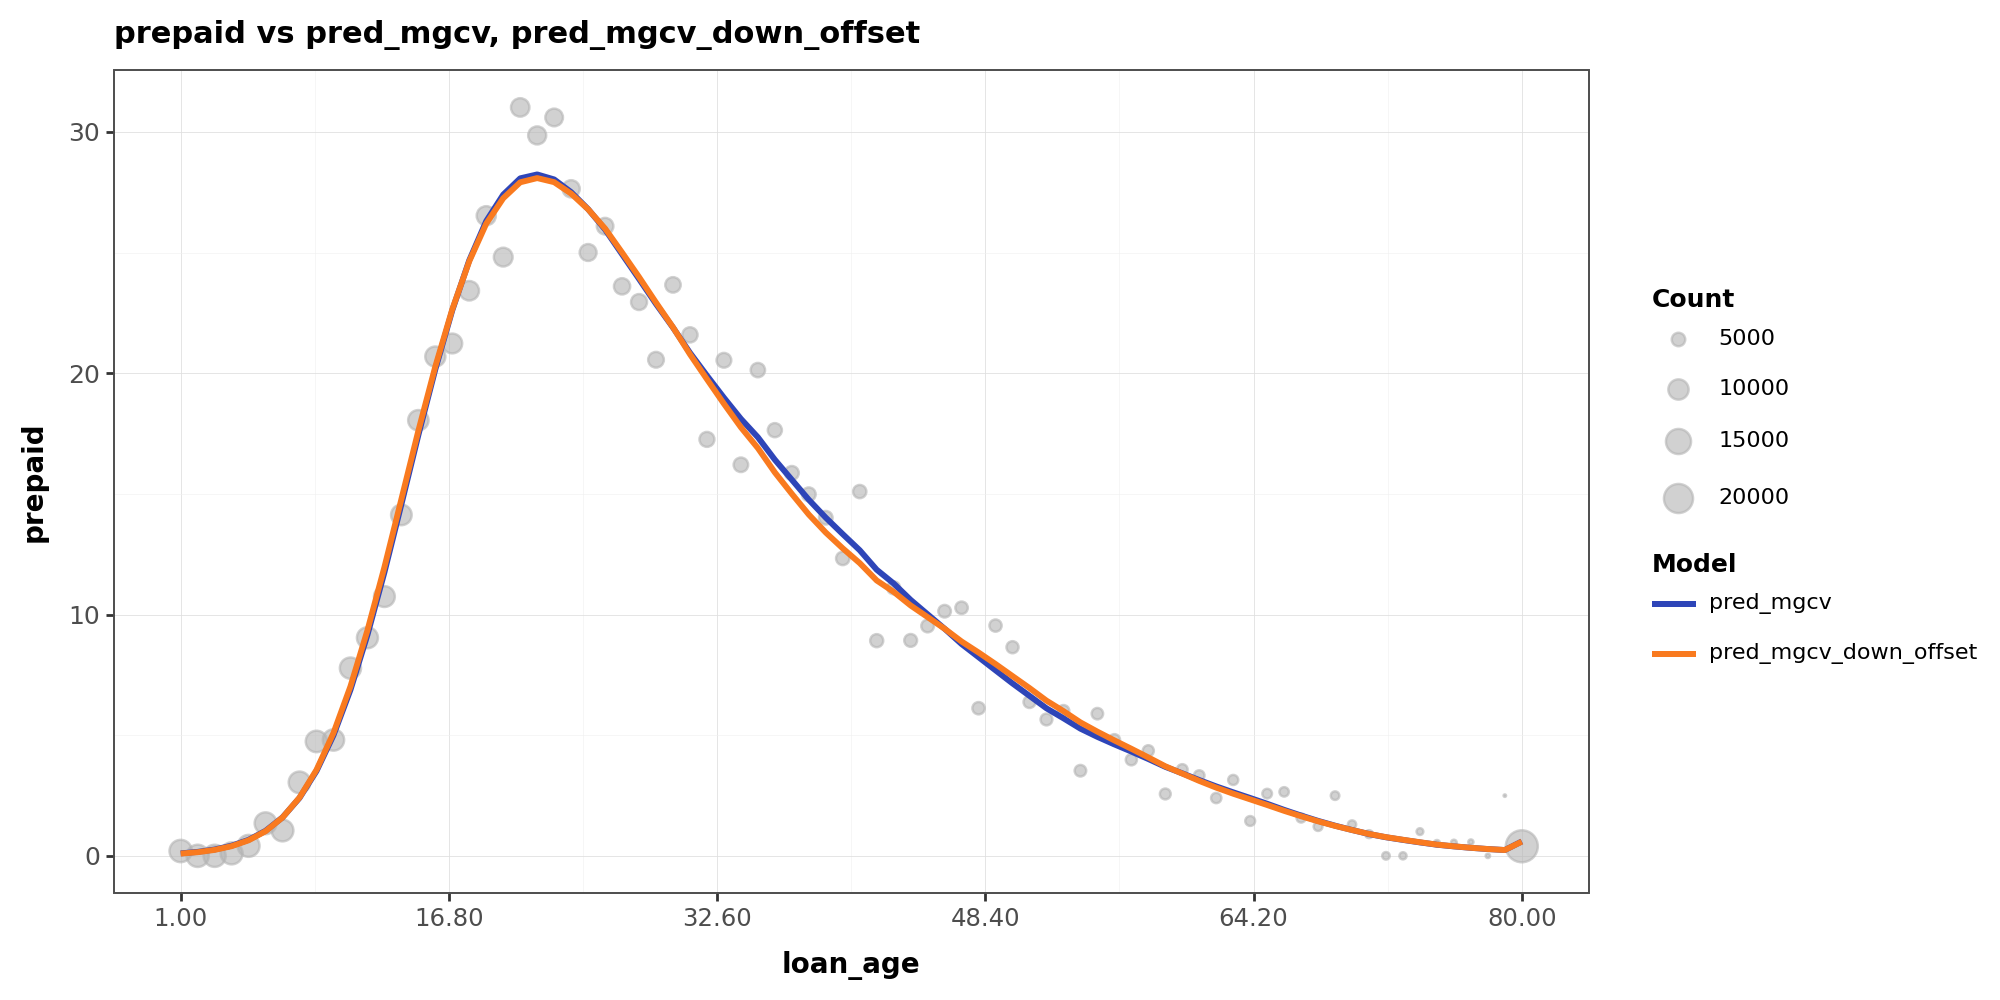

In [35]:
plot_binned_actual_vs_pred_plotnine(
    df_model, x_col='loan_age', act_col='prepaid', pred_col=['pred_mgcv', 'pred_mgcv_down_offset'],
    bins=False, y_transform=smm_to_cpr_pct, figsize=(10, 5),
)

## `mgcv` Fit on Downsampled Data (Naive + Post-hoc KZ)

Fit on the downsampled data without any offset, then correct predictions on the full data by shifting the log-odds by `kz_correction`.

In [36]:
mgcv_down_naive = MgcvBamWrapper()
mgcv_down_naive.fit(
    df=df_down,
    formula="prepaid ~ s( loan_age ) + s( incentive )",
    family="binomial"
)

R callback write-console: In addition:   
R callback write-console: Warning message:
  
R callback write-console: In strip_gam_object(gam_fit) :  
R callback write-console: 
   
R callback write-console:  offset is not zero (make sure this is intended).
  


Model fitted from DataFrame: py_df_to_r=0.19s | bam_fit=0.29s


MgcvBamWrapper(fitted, formula='prepaid ~ s( loan_age ) + s( incentive )')

In [37]:
logit_naive = mgcv_down_naive.predict(df=df_model, type="link")
df_model['pred_mgcv_down'] = _sigmoid(logit_naive + kz_correction)

[strip_gam_object] 4 MB → 0 MB
[R predict_bam] n=501494 | convert=0.000s strip=0.015s predict=0.214s | total=0.229s
Predictions made from DataFrame[501494]: select_cols=0.00s | py_to_r=1.70s | r_predict=0.24s | r_to_py=0.00s | total=1.94s


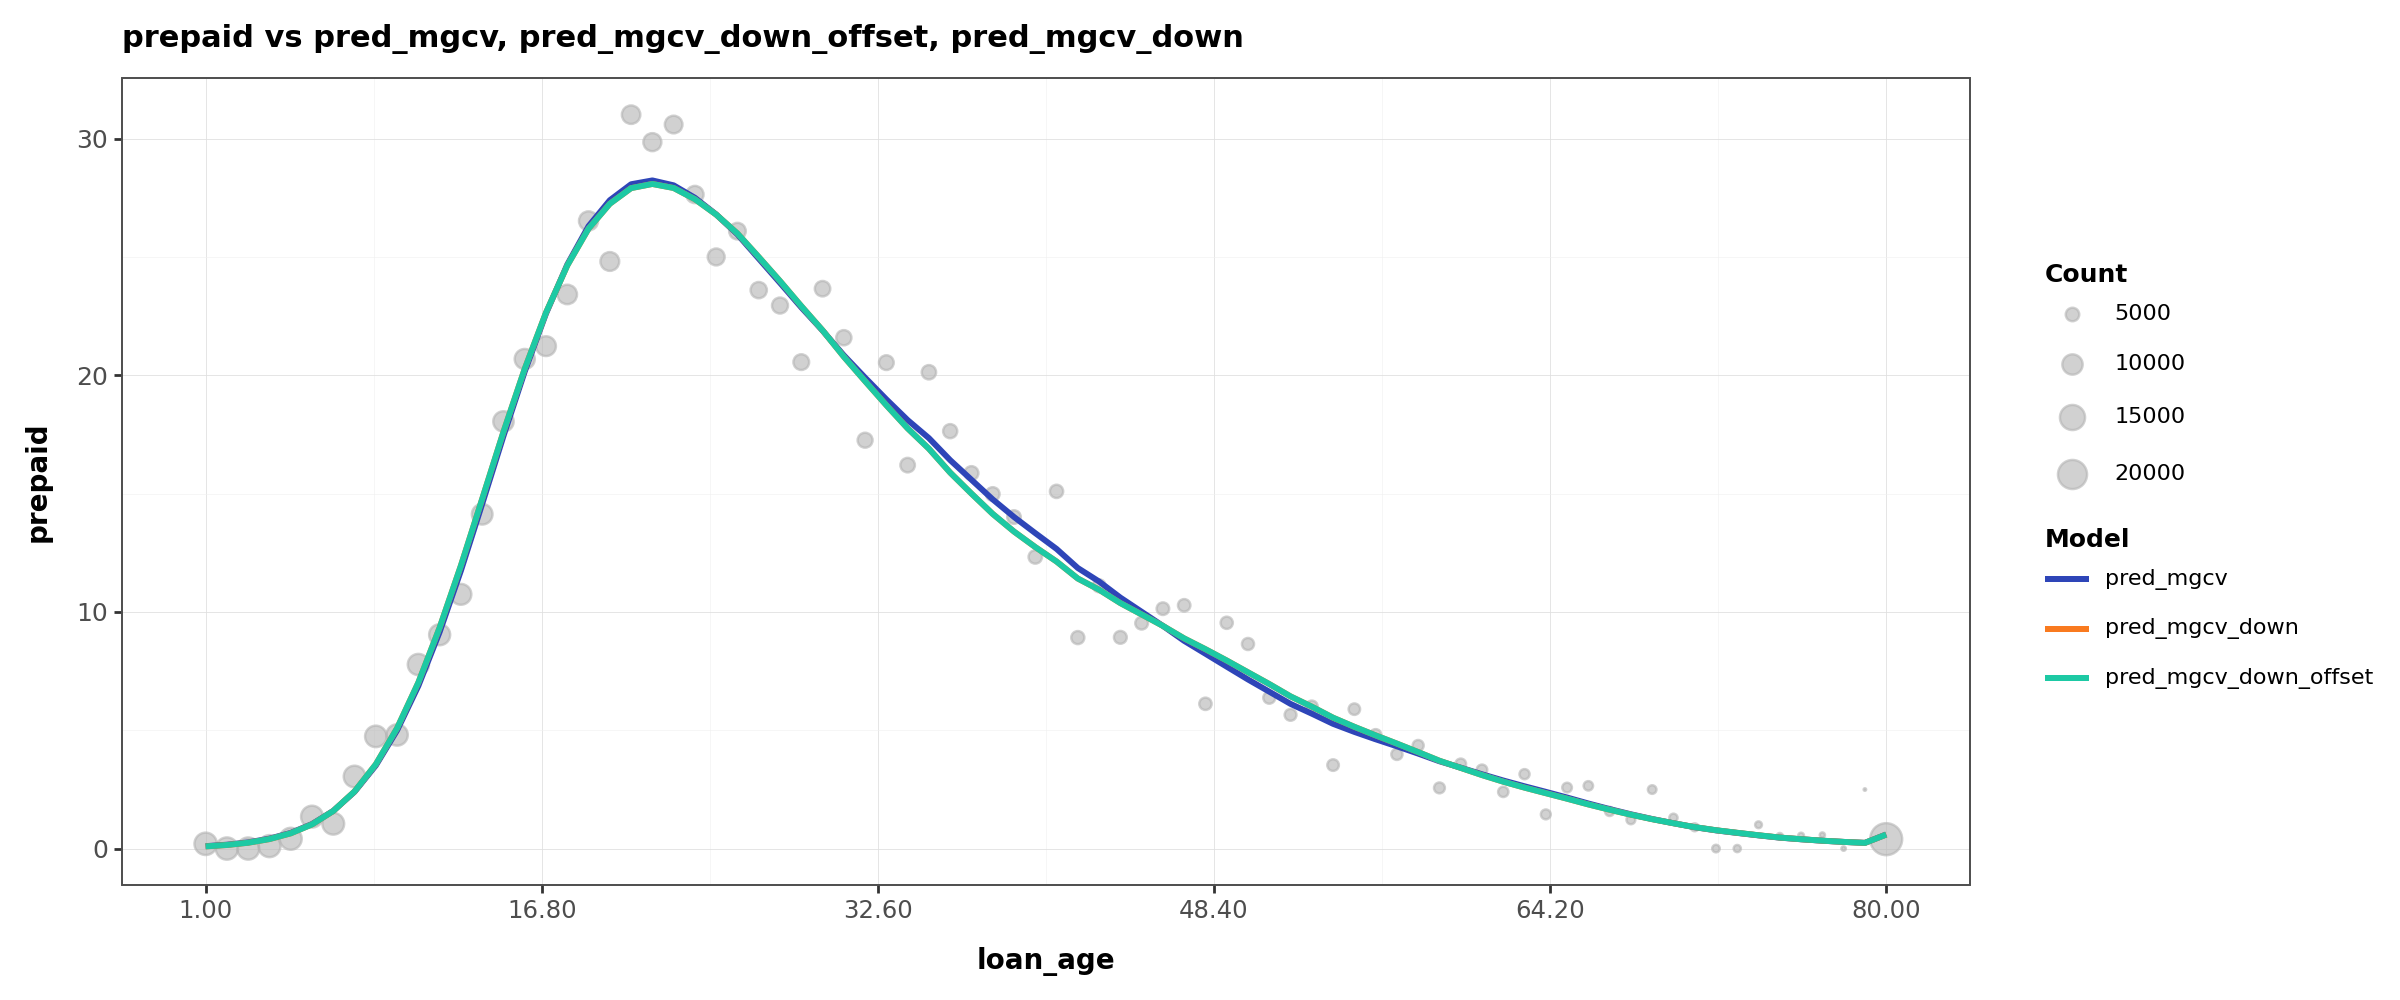

In [38]:
pred_cols_all = ['pred_mgcv', 'pred_mgcv_down_offset', 'pred_mgcv_down']

plot_binned_actual_vs_pred_plotnine(
    df_model, x_col='loan_age', act_col='prepaid', pred_col=pred_cols_all,
    bins=False, y_transform=smm_to_cpr_pct, figsize=(12, 5),
)

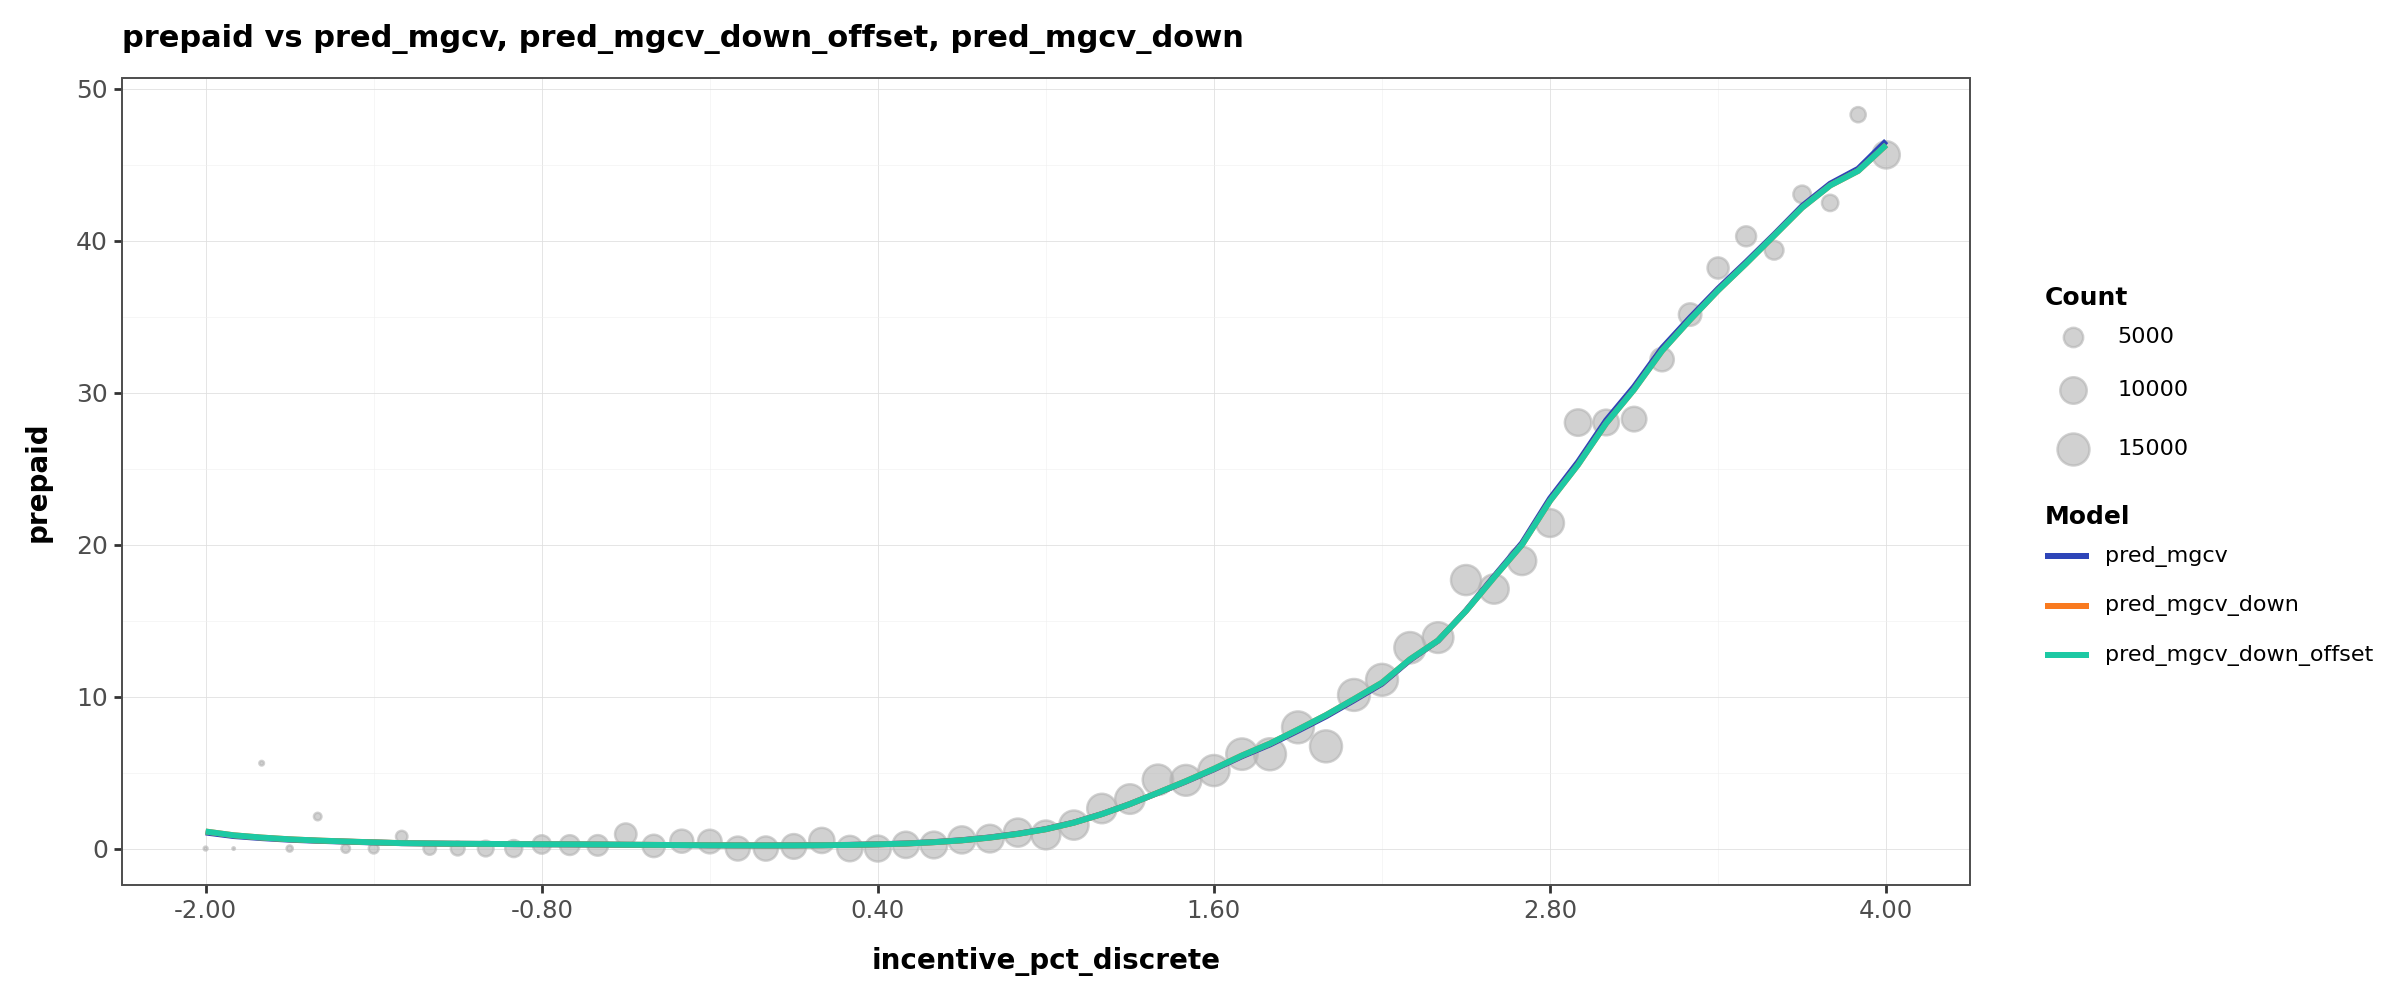

In [39]:
plot_binned_actual_vs_pred_plotnine(
    df_model, x_col='incentive_pct_discrete', act_col='prepaid', pred_col=pred_cols_all,
    bins=False, y_transform=smm_to_cpr_pct, figsize=(12, 5),
)

## Stratified Downsampling by Age Bucket

Downsample non-events within each `loan_age` to hit a target event rate per bucket.
Each bucket gets its own KZ offset, so the offset column varies across rows.
This is where `offset()` truly adds value -- the correction is observation-specific.

In [40]:
rng_strat = np.random.default_rng(42)

frames = []
for age, grp in df_model.groupby('loan_age'):
    events = grp[grp['prepaid'] == 1]
    nonevents = grp[grp['prepaid'] == 0]
    n_ev = len(events)
    n_nonev = len(nonevents)
    pi_true_i = n_ev / len(grp) if len(grp) > 0 else 0

    if n_ev == 0 or pi_true_i >= target_event_rate:
        bucket = grp.copy()
        bucket['correction'] = 0.0
    else:
        n_nonev_target = int(n_ev * (1 - target_event_rate) / target_event_rate)
        n_nonev_target = min(n_nonev_target, n_nonev)
        sampled = nonevents.iloc[rng_strat.choice(n_nonev, n_nonev_target, replace=False)]
        bucket = pd.concat([events, sampled])

        pi_down_i = n_ev / len(bucket)
        kz_i = np.log((pi_true_i * (1 - pi_down_i)) / (pi_down_i * (1 - pi_true_i)))
        bucket['correction'] = -kz_i

    frames.append(bucket)

df_down_strat = pd.concat(frames).sort_index()

print(f"Stratified downsampled: {len(df_down_strat):,} rows  |  event rate = {df_down_strat['prepaid'].mean():.4f}")
print(f"Offset range: [{df_down_strat['correction'].min():.4f}, {df_down_strat['correction'].max():.4f}]")
print(f"Unique offset values: {df_down_strat['correction'].nunique()}")

Stratified downsampled: 80,865 rows  |  event rate = 0.0620
Offset range: [0.0000, 7.1699]
Unique offset values: 76


In [41]:
mgcv_strat_offset = MgcvBamWrapper()
mgcv_strat_offset.fit(
    df=df_down_strat,
    formula="prepaid ~ s( loan_age ) + s( incentive ) + offset( correction )",
    family="binomial"
)

df_model['correction'] = 0
df_model['pred_mgcv_strat_offset'] = mgcv_strat_offset.predict(df=df_model)

Model fitted from DataFrame: py_df_to_r=0.38s | bam_fit=0.43s
[strip_gam_object] 7 MB → 1 MB
[R predict_bam] n=501494 | convert=0.000s strip=0.016s predict=0.157s | total=0.173s
Predictions made from DataFrame[501494]: select_cols=0.00s | py_to_r=2.28s | r_predict=0.18s | r_to_py=0.00s | total=2.46s


In [42]:
mgcv_strat_naive = MgcvBamWrapper()
mgcv_strat_naive.fit(
    df=df_down_strat,
    formula="prepaid ~ s( loan_age ) + s( incentive )",
    family="binomial"
)

logit_strat = mgcv_strat_naive.predict(df=df_model, type="link")
df_model['pred_mgcv_strat_naive'] = _sigmoid(logit_strat + kz_correction)

R callback write-console: In addition:   
R callback write-console: Warning message:
  
R callback write-console: In strip_gam_object(gam_fit) :  
R callback write-console: 
   
R callback write-console:  offset is not zero (make sure this is intended).
  


Model fitted from DataFrame: py_df_to_r=0.40s | bam_fit=0.37s
[strip_gam_object] 7 MB → 1 MB
[R predict_bam] n=501494 | convert=0.000s strip=0.015s predict=0.125s | total=0.141s
Predictions made from DataFrame[501494]: select_cols=0.00s | py_to_r=1.68s | r_predict=0.15s | r_to_py=0.00s | total=1.83s


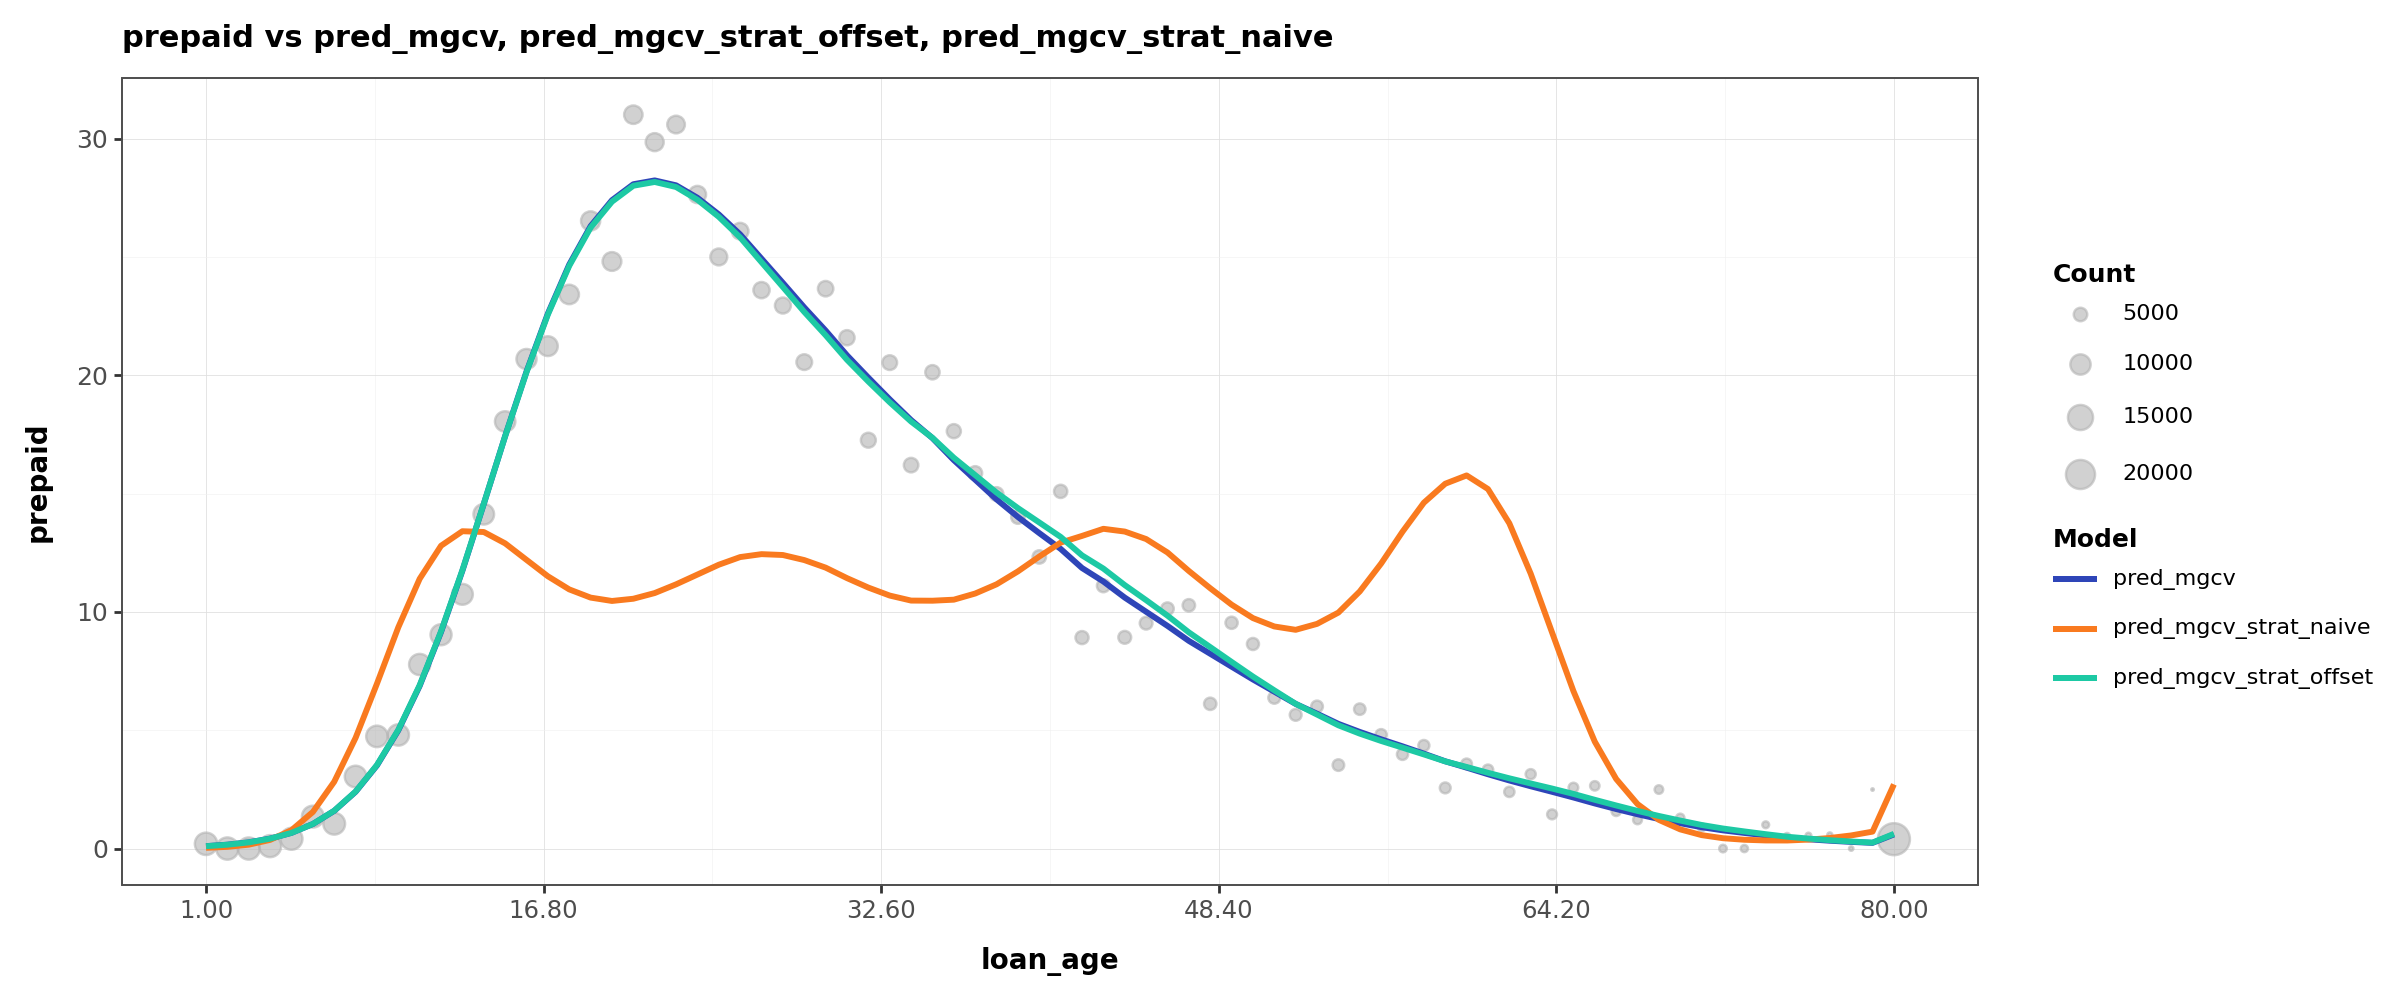

In [43]:
pred_cols_strat = ['pred_mgcv', 'pred_mgcv_strat_offset', 'pred_mgcv_strat_naive']

plot_binned_actual_vs_pred_plotnine(
    df_model, x_col='loan_age', act_col='prepaid', pred_col=pred_cols_strat,
    bins=False, y_transform=smm_to_cpr_pct, figsize=(12, 5),
)

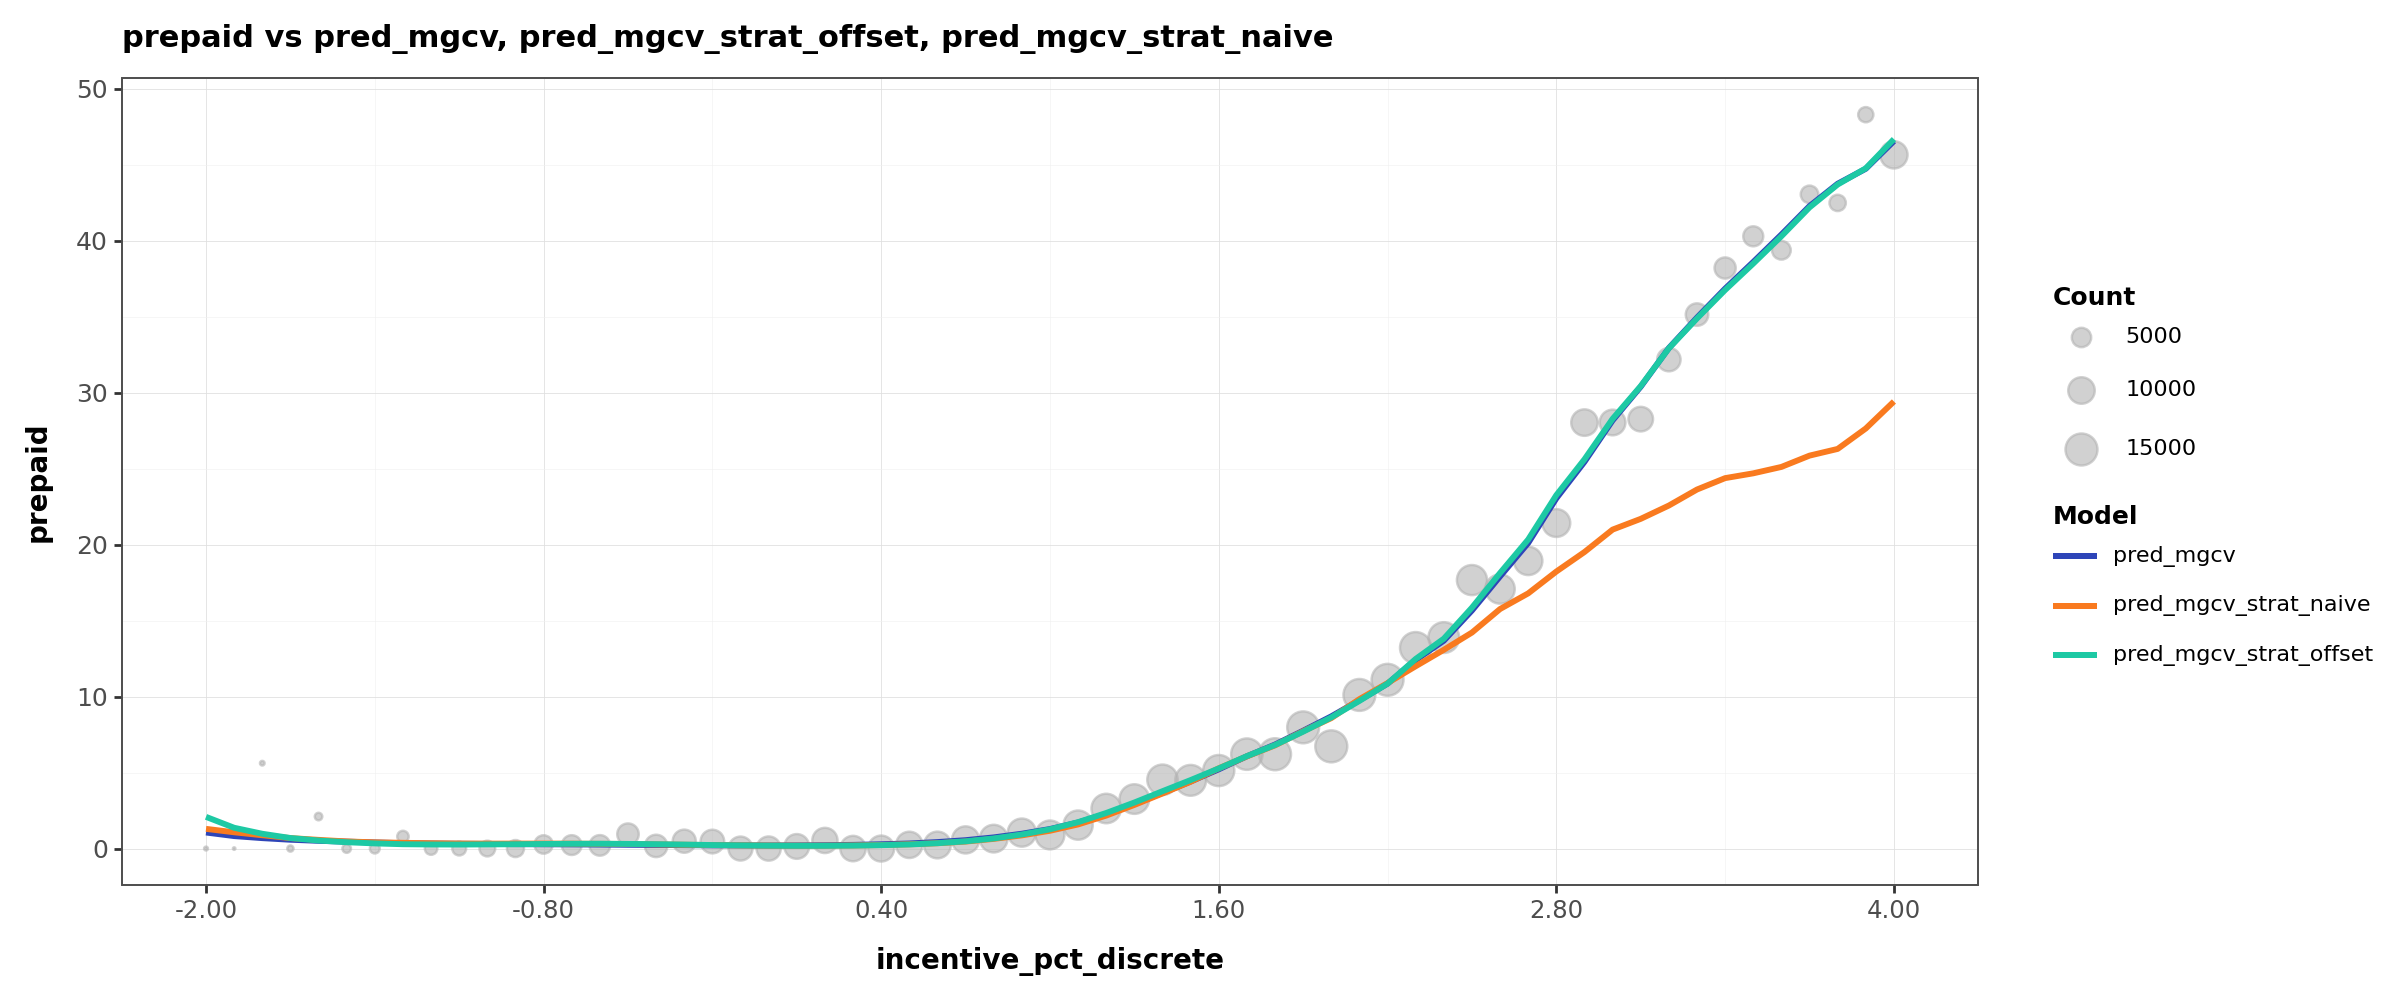

In [44]:
plot_binned_actual_vs_pred_plotnine(
    df_model, x_col='incentive_pct_discrete', act_col='prepaid', pred_col=pred_cols_strat,
    bins=False, y_transform=smm_to_cpr_pct, figsize=(12, 5),
)

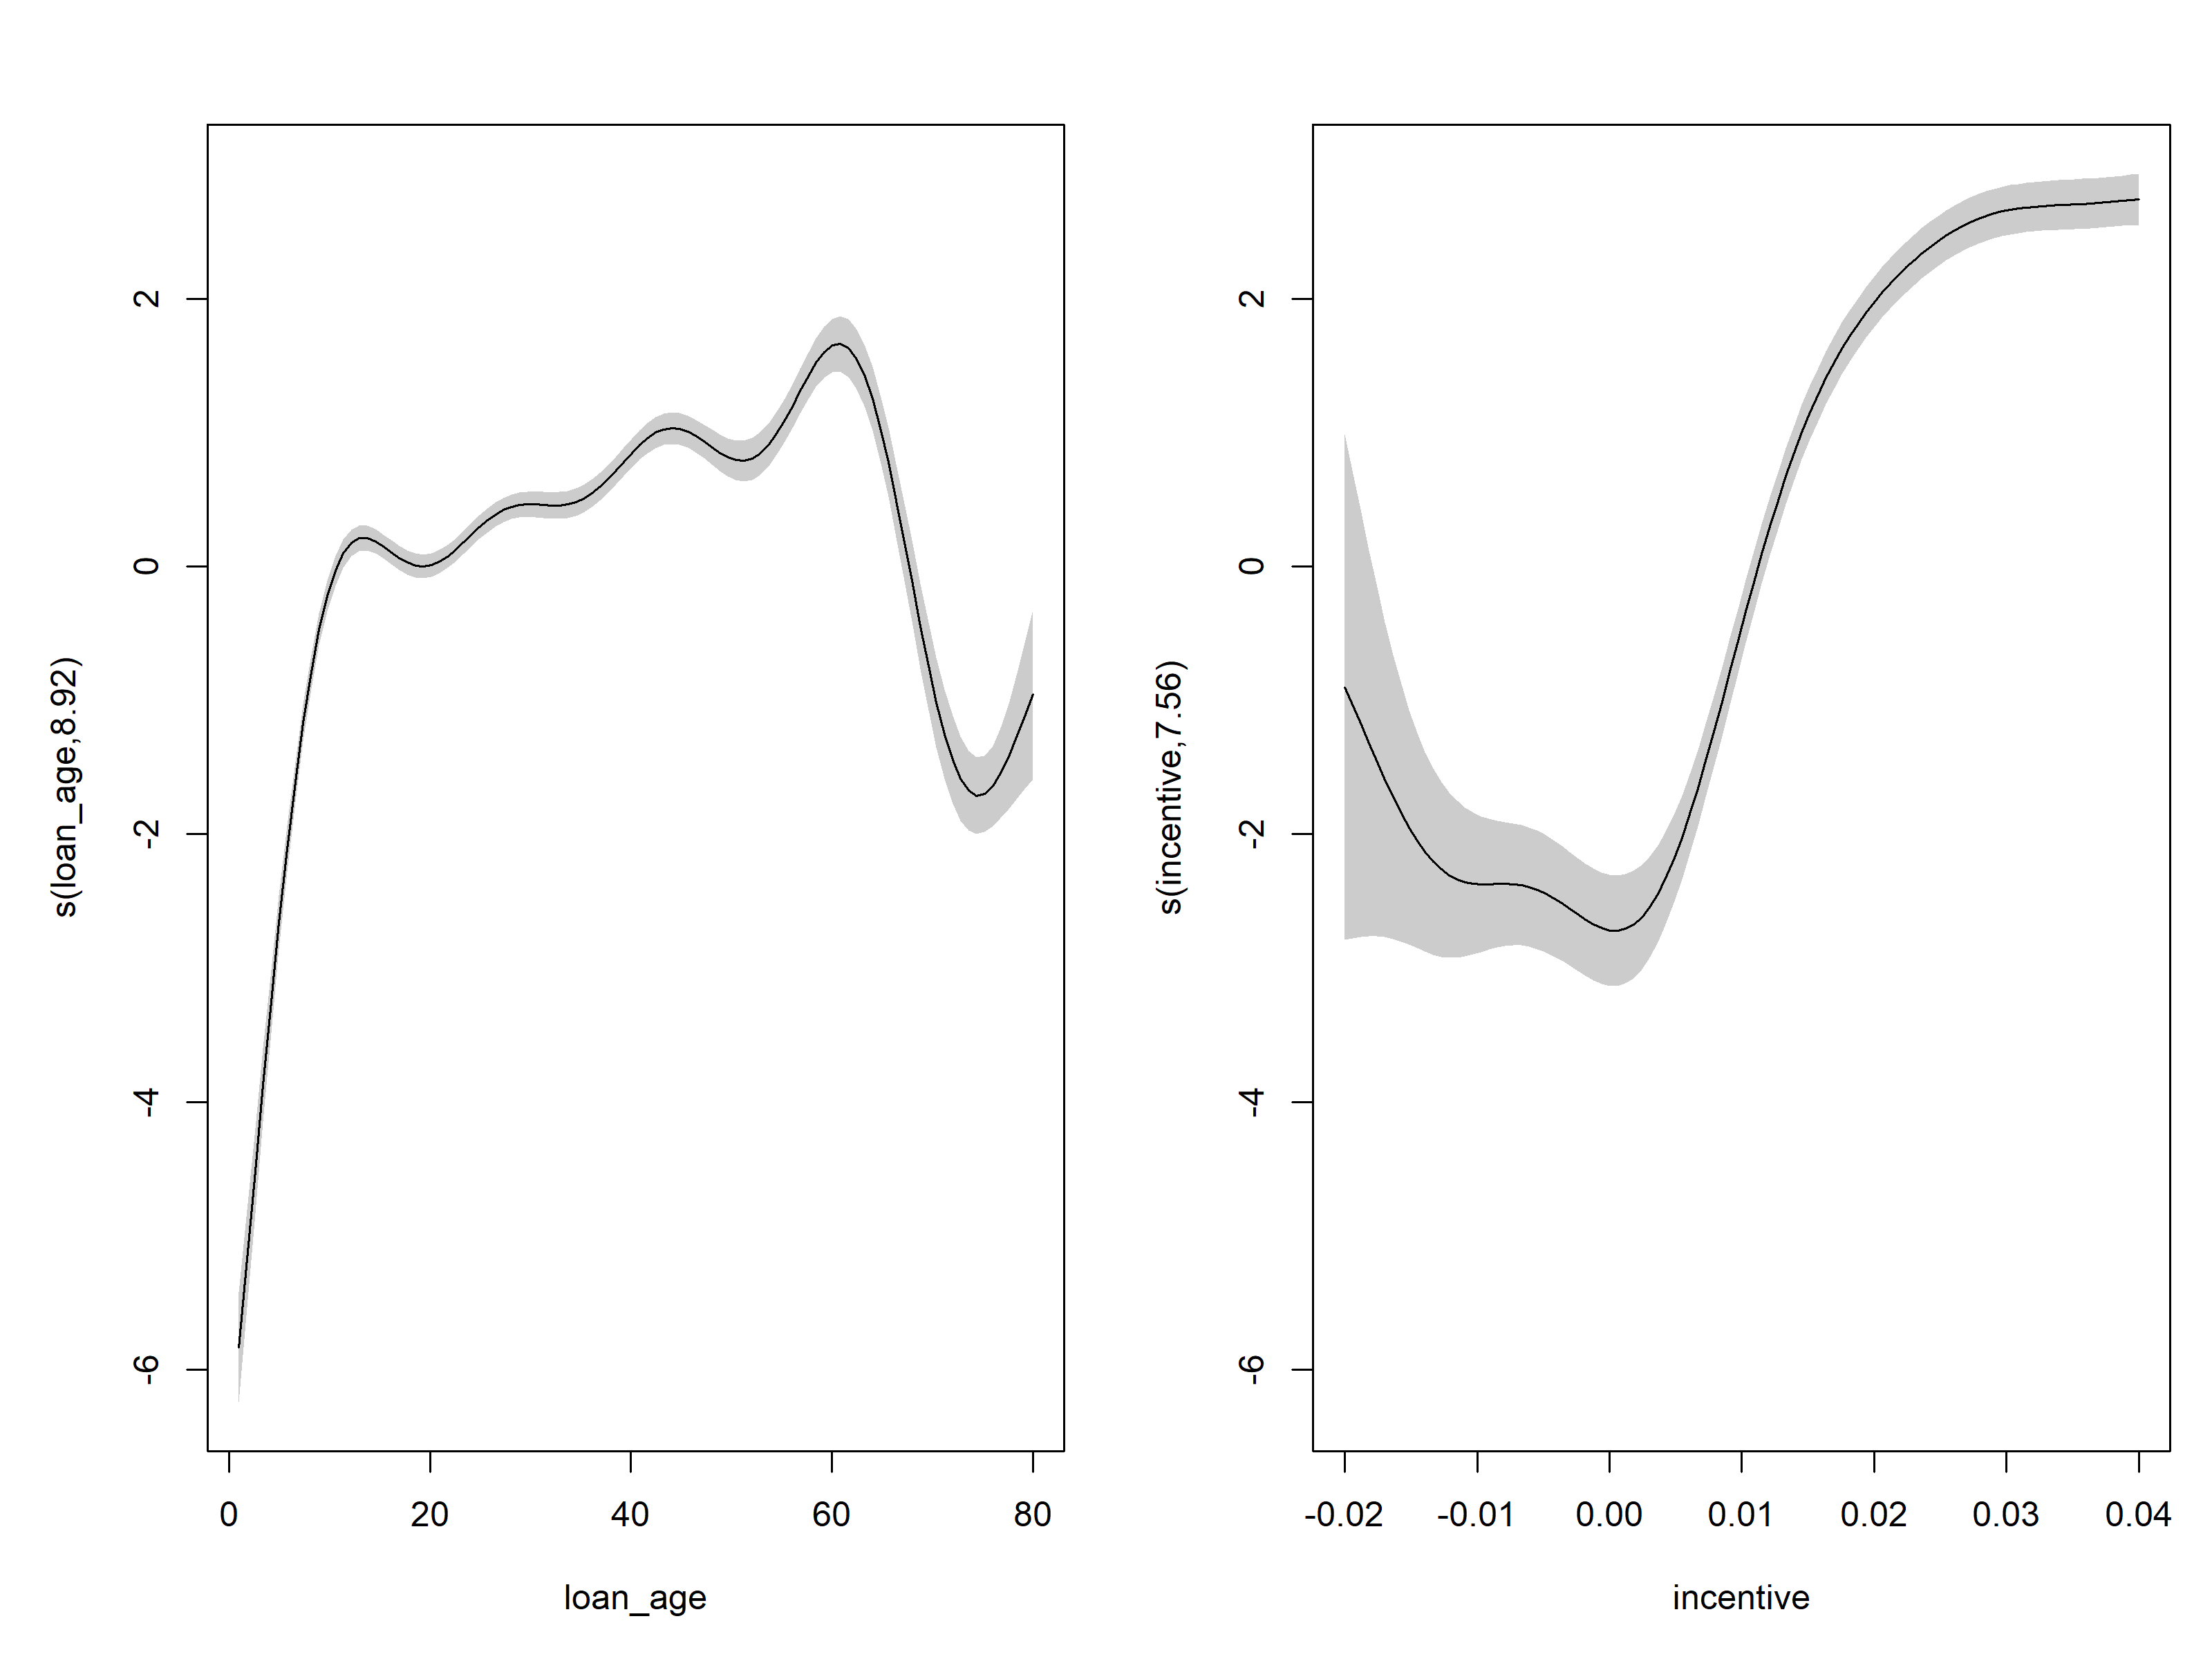

In [45]:
mgcv_strat_naive.plot()

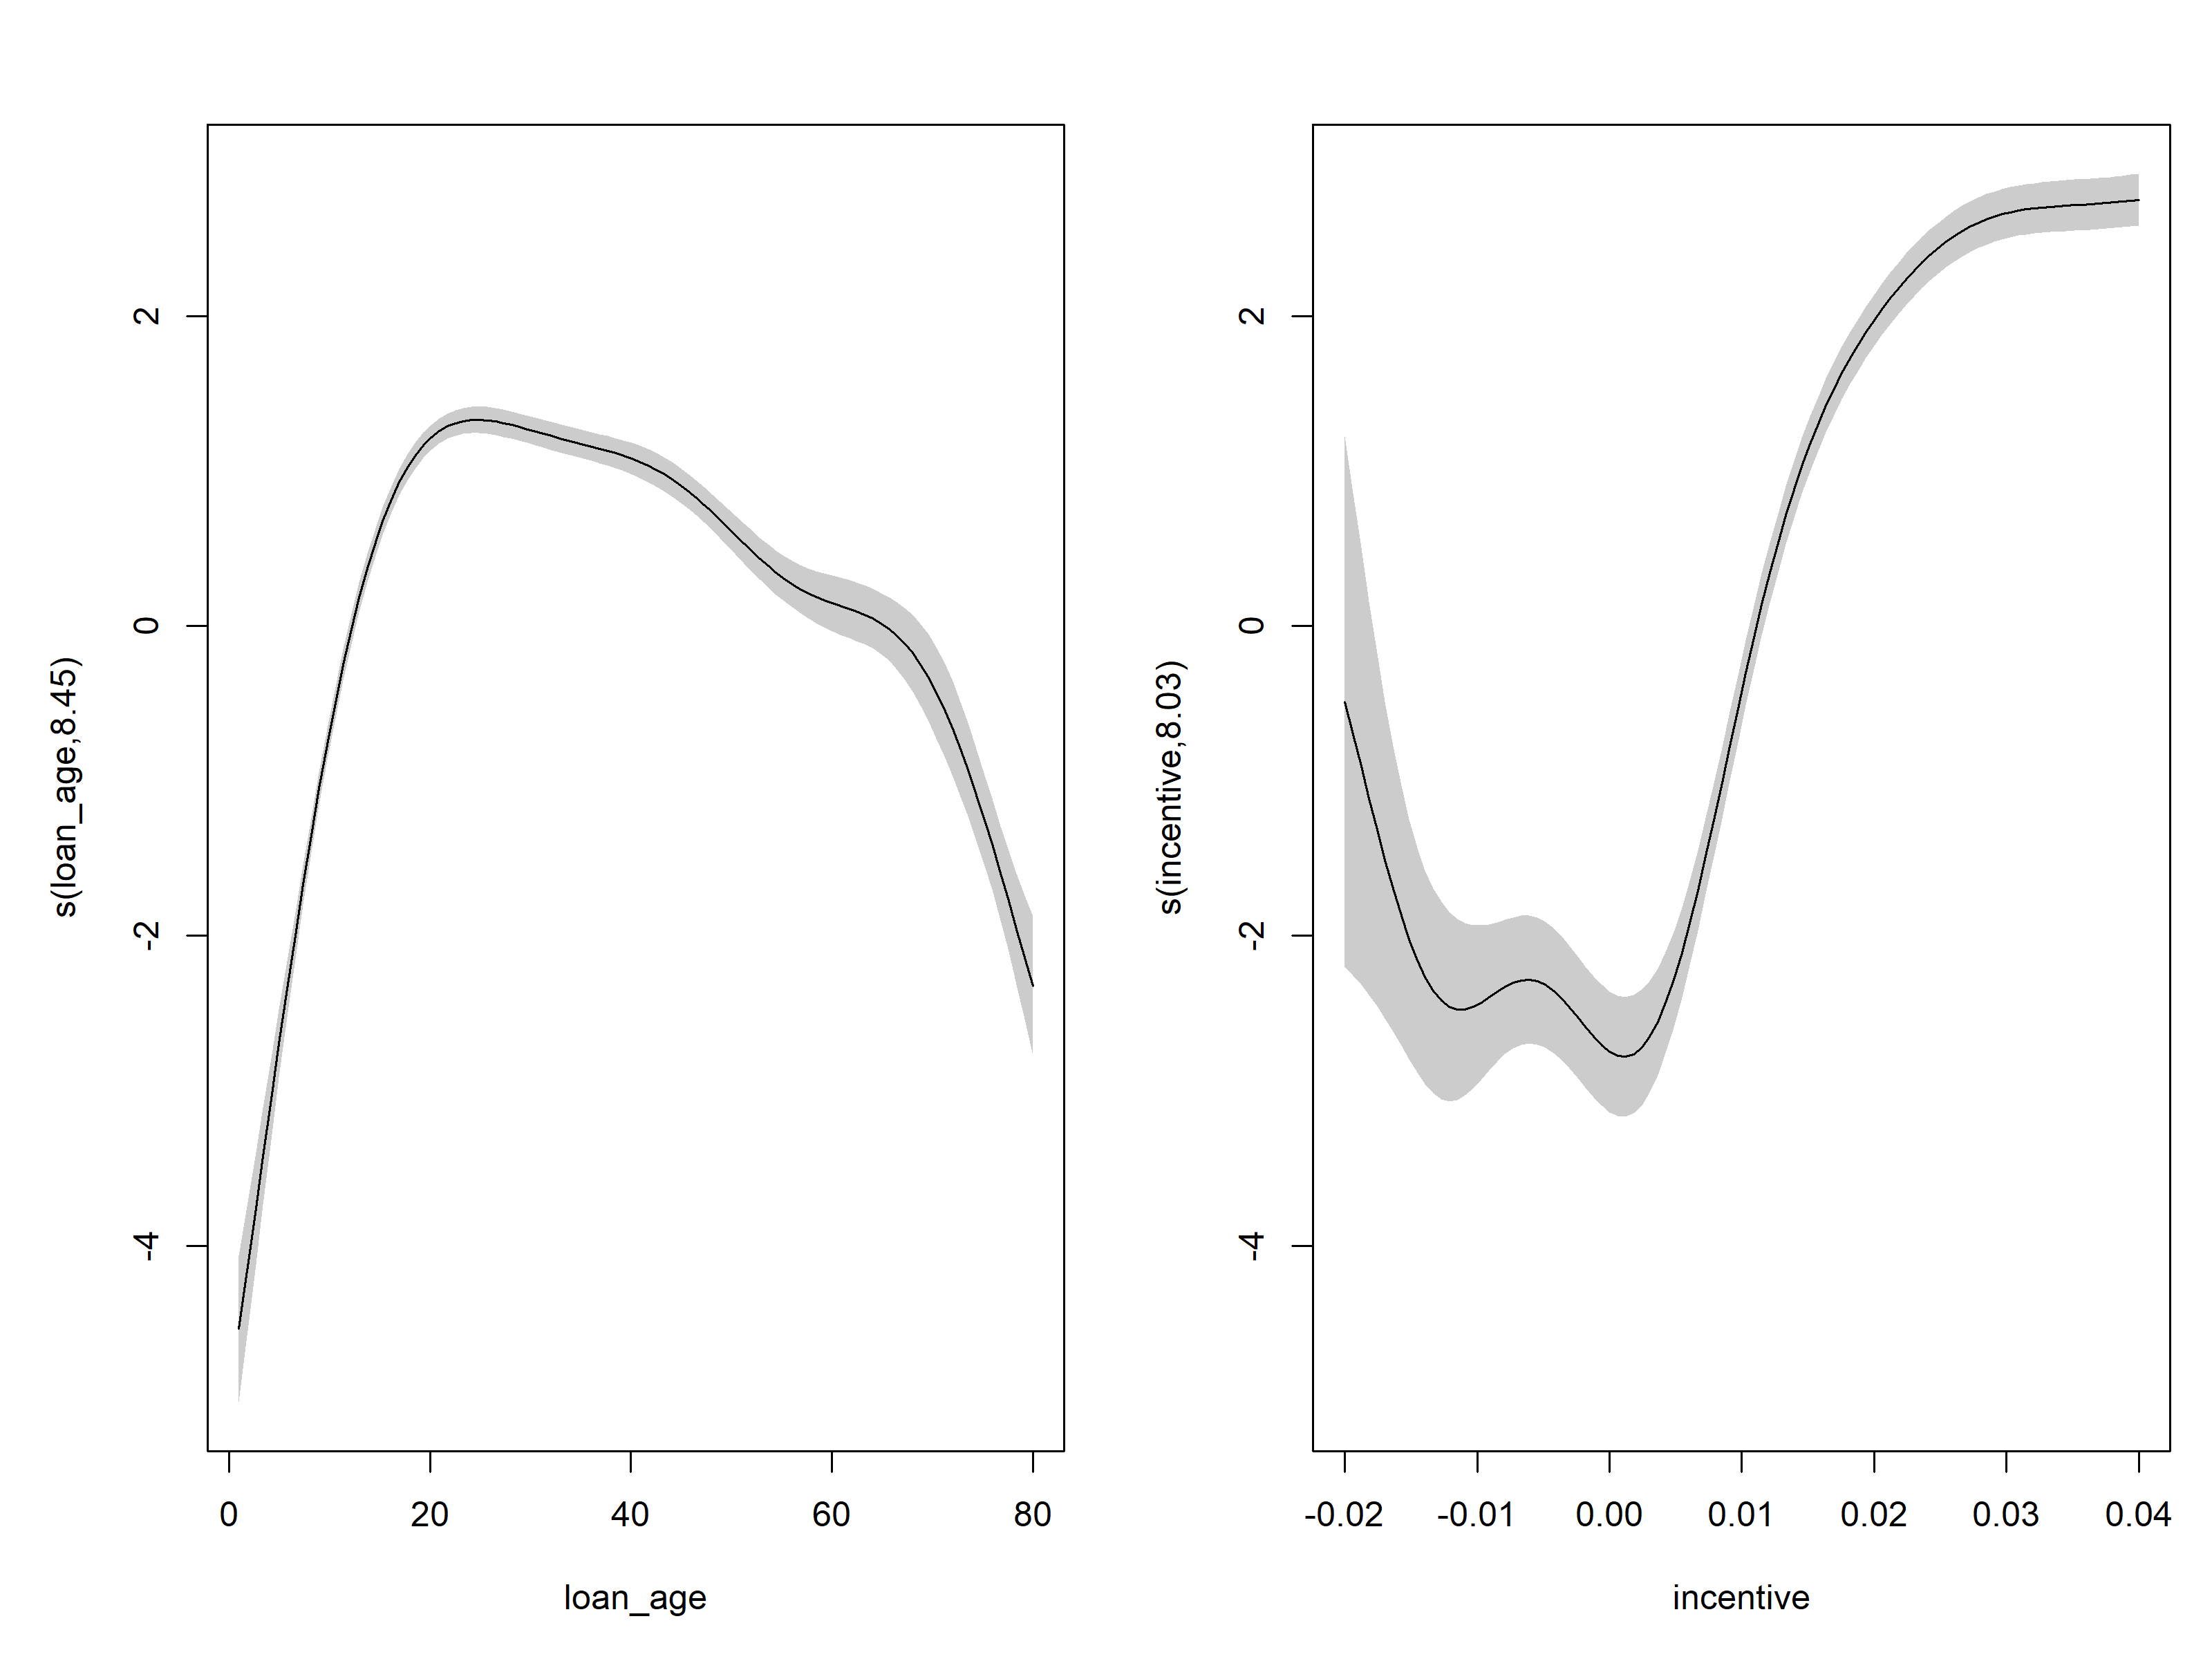

In [46]:
mgcv_strat_offset.plot()